Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433

* https://www.kaggle.com/c/lish-moa/discussion/193878

* https://tsumit.hatenablog.com/entry/2020/06/20/044835

* https://www.kaggle.com/kushal1506/moa-pytorch-feature-engineering-0-01846


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pseudo labeling (thresholds:0.5), timeout
# Version = "v9" # pseudo labeling (thresholds:0.6), timeout
# Version = "v10" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pseudo labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
# Version = "v19" # SMOTE(k_neighbors=2→3),
# Version = "v20" # Modifications with confidence, Removed the Calibration, SMOTE(k_neighbors=2), 
# Version = "v21" # DEBUG = False
# Version = "v22" # minor modifications
# Version = "v23" # TOP100→PCA→UMAP(n_components=3)
# Version = "v24" # TOP100→PCA→UMAP(n_components=10), UMAP(n_components=2→3)
# Version = "v25" # Feature engineering based on Feature importance
# Version = "v26" # Modify pseudo labeling func to exclude low confidence pseudo labels in the TEST data.
# Version = "v27" # LGBMClassifie:clf.predict→clf.predict_proba
# Version = "v28" # Calibration (No calbration:CV:0.06542)
# Version = "v29" # Remove Calibration, is_unbalance': True, SMOTE(k_neighbors=2→3), Modify pseudo labeling func to include low confidence pseudo labels in the TEST data, target_rate *= 1.2
# Version = "v30" # drop_duplicates(keep="last")
# Version = "v31" # target_rate *= 1.1, if Threshold <= 0.2: break, if sum(p_label)*1.5 >= check: break, if sum(p_label) <= check*1.5: break
# Version = "v32" # y_prob.probability.quantile(0.3), if Threshold >= 0.95: break
# Version = "v33" # RankGauss, Scaled by category, SMOTE(k_neighbors=2),
# Version = "v34" # RankGauss apply c-columns, remove TOP100, Add f_diff = lambda x: x - med, Create features

Version = "v35" # f_div = lambda x: ((x+d)*10 / (abs(med)+d))**2, f_diff = lambda x: ((x-med)*10)**2, select features

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import imblearn
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)
print("imblearn Version: ", imblearn.__version__)

lightgbm Version:  2.3.1
numpy Version:  1.18.5
pandas Version:  1.1.1
imblearn Version:  0.7.0


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()

def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=30
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    
    return train, test

In [8]:
# Manual annotation by myself
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

,sig_id,nonscored1,nonscored2
0,adenylyl_cyclase_activator,adenylyl_cyclase_inhibitor,NaN
1,aldehyde_dehydrogenase_inhibitor,alcohol_dehydrogenase_inhibitor,NaN
2,antiarrhythmic,na_k-atpase_inhibitor,potassium_channel_blocker
3,anticonvulsant,gaba_gated_chloride_channel_blocker,NaN
4,antifungal,fungal_ergosterol_inhibitor,fungal_lanosterol_demethylase_inhibitor
5,antihistamine,histamine_release_inhibitor,NaN
6,atp-sensitive_potassium_channel_antagonist,atp-sensitive_potassium_channel_inhibitor,NaN
7,bacterial_membrane_integrity_inhibitor,bacterial_protein_synthesis_inhibitor,NaN
8,calcineurin_inhibitor,t_cell_inhibitor,NaN
9,catechol_o_methyltransferase_inhibitor,dopamine_release_enhancer,NaN


In [9]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [10]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training Utils

In [11]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [12]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    target_rate *= (-0.001*target.sum()+1.1)

    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    n_target = max(500, len(trt))
    
    logger.info(f"{target_col} , len(trt) : {len(trt)}")
        
    othr = train[target==0].copy().reset_index(drop=True)
    othr = othr.drop("sig_id", axis=1)
    othr = othr.sample(n=n_target, random_state=42)
    othr["target"] = 0
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_train = X_train.fillna(0)
    
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)


    if len(trt) < n_target:
        sm = SMOTE(k_neighbors=2, n_jobs=2, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y = pseudo_labeling(X_train, y_train, X_test, target_rate, target_col)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [13]:
#===========================================================
# pseudo_labeling
#===========================================================

def pseudo_labeling(X_train, y_train, X_test, target_rate, target_col, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    feature_importance_df = pd.DataFrame()
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = X.columns
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict_proba(X_val, num_iteration=clf.best_iteration_)[:, 1]
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
            
            # feature importance with target col
            _importance_df["importance"] = clf.feature_importances_
            feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)
        
        auc_score = roc_auc_score(y_preds[:, 0], y_preds[:, 1])
        logger.info(f"{iter_} / {max_iter} AUC score:{auc_score:.3f}") 
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        
        if iter_ == 1:
            Threshold = y_preds.iloc[:, 1].median()
            
        logger.info(f"Threshold: {Threshold}")
            
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] < Threshold, 1).copy()
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] >= Threshold, 0).copy()
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"Remove_noisy_labels: {len(y)-len(y_corect)} → positive_corect_labels: {sum(y_corect)}/{len(y_corect)}")
            
        # Remove low confidence labels
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        
        percentile = y_prob.probability.quantile(0.3)
        high_conf_0 = min(y_prob.probability.min()*30, percentile)
        high_conf_1 = max(y_prob.probability.max()*0.6,Threshold)
        logger.info(f"30th percentile: {percentile:.5f}")
        
        p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"p_label_rate: {p_label_rate:.5f} Vs.target_rate: {target_rate:.5f}, Num_p_label: {sum(p_label)}, conf_0:{high_conf_0:.5f}, conf_1:{high_conf_1:.5f}")
        
        # Set the params of threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target) * 1.1
        if p_label_rate*3 < target_rate:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label)*1.5 >= check: break
                Threshold -= 0.04
                if Threshold <= 0.2: break
                high_conf_1 = max(y_prob.probability.max()*0.6,Threshold)
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
               
                
        if p_label_rate > target_rate*3:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label) <= check*1.5: break
                Threshold += 0.04
                if Threshold >= 0.95: break
                high_conf_1 = max(y_prob.probability.max()*0.6,Threshold)
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
                
        if iter_ == max_iter:
            X_conf = X_test.copy()
        else:
            X_conf = X_test[X_test.index.isin(conf_idx)].copy()
            
        logger.info(f"threshold:{Threshold:.2f}, positive p_label:{sum(p_label)}/{len(p_label)}, p_label_rate: {sum(p_label)/len(p_label):.5f}")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates(keep="last").reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
        logger.info(f"positive y_label:{sum(y)}/{len(y)}, y_label_rate: {sum(y)/len(y):.5f}")
        
    if DEBUG:
        show_feature_importance(feature_importance_df, target_col, num=10)
        
    return X, y

In [14]:
def convert_label(df, conf_0, conf_1, threshold=0.5):
    df = df.copy()
    Probability = df.iloc[:,0]
    # Remove low confidence labels
    conf_index = df[(Probability <= conf_0) & (conf_1 <= Probability)].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [15]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': Learning_rate,
    'objective': "binary",
    'colsample_bytree':0.5,
    'subsample':0.8,
    'subsample_freq':5,
    'reg_alpha':0.1,
    'reg_lambda':0.1,
    'random_state':SEED,
    'n_jobs':2,
}

In [16]:
def show_feature_importance(feature_importance_df, title="all", num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    
    hight = int(num//3.3)
    plt.figure(figsize=(8, hight))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title(f'{title}_Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./{title}_feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [17]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [18]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [19]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [20]:
train['WHERE'], test['WHERE'] = 'train', 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,train
1,id_000779bfc,1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,train
2,id_000a6266a,1,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,train
3,id_0015fd391,1,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,train
4,id_001626bd3,1,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,1,0,0,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600,test
27792,id_ff925dd0d,1,0,0,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934,test
27793,id_ffb710450,1,2,0,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504,test
27794,id_ffbb869f2,1,1,1,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484,test


In [21]:
# Select control data
ctl = train[(train.cp_type==0)]
ctl

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
25,id_0054388ec,0,1,0,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-0.6828,-0.6594,-0.2043,0.3571,-0.1319,0.2187,0.0737,0.6498,-1.4820,train
40,id_007bfbb91,0,0,1,-1.3200,-1.7340,-0.0741,1.5440,-1.8290,-0.0951,...,1.0340,0.7393,1.1020,0.3786,0.2636,-0.5751,0.3362,0.8543,0.9180,train
47,id_008a986b7,0,1,1,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,...,-0.1866,0.7629,0.3288,-0.9915,-0.3694,-0.4979,0.5281,-0.9245,-0.9367,train
63,id_009d8340f,0,0,1,0.4471,-0.0839,-0.3864,0.3196,0.2584,-0.3156,...,0.3939,0.7665,0.7932,-0.6804,-0.0435,0.0949,0.2000,-0.4326,0.9364,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23729,id_ff1f9e5fc,0,0,0,0.0465,0.6430,-0.2453,0.3521,0.6195,-0.6659,...,0.1621,-0.2065,0.8314,-0.1891,-0.0074,0.2131,-0.1419,-0.2422,0.0457,train
23747,id_ff469c482,0,2,0,-0.6204,-1.3800,-1.1880,-0.6573,-0.8408,-0.2447,...,0.7366,0.5468,1.1450,0.5254,0.6224,-0.9630,0.8872,-0.0742,-0.6777,train
23768,id_ff89331ca,0,2,1,-0.1051,0.4335,0.3648,-0.0525,-0.3632,-0.3228,...,0.4885,0.4963,0.9434,-0.4779,0.6951,0.9517,-0.8110,-0.1748,-0.3626,train
23793,id_ffd26f361,0,1,1,0.6008,0.2781,-0.3319,-0.8782,0.9281,0.7535,...,0.9569,-0.2065,-0.4918,0.7863,0.0504,0.8813,0.7757,-0.5272,0.7082,train


In [22]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_0054388ec,0,1,0,-0.6696,-0.27180,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
1,id_01b05de6c,0,1,0,-0.3176,0.48512,-0.3773,0.5555,-0.4877,0.3413,...,-0.6163,0.8001,0.3389,0.7437,0.7533,0.2406,0.5057,0.8017,1.0280,train
2,id_020ba48d9,0,1,0,0.8094,-0.33390,1.1130,-0.4192,0.4545,-0.4771,...,-0.4414,-0.2442,0.0557,-0.6597,-0.3713,-0.6929,-0.3258,0.3602,-0.0595,train
3,id_02c93b4a5,0,1,0,-0.0884,-1.54100,0.5562,0.4661,-0.1683,0.9515,...,0.4766,0.9697,0.4613,0.8957,0.8227,1.2300,1.7180,0.6542,0.0580,train
4,id_03bc6d412,0,1,0,0.8431,0.09310,-0.0958,-0.4337,1.0690,-0.6440,...,-1.1510,-0.5010,-0.2736,0.1270,0.3511,0.1233,-0.8520,0.1767,0.1153,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,id_fbb620181,0,2,1,-0.3490,0.72970,-4.1480,-1.0030,2.4070,-0.9784,...,-1.4260,-0.8613,-0.0243,-0.6109,0.6377,-1.2590,-0.7238,-0.7734,-0.1274,train
1862,id_fbba92030,0,2,1,-0.8921,1.13520,0.4227,1.3270,-0.9839,-0.8469,...,1.1340,0.7007,1.3320,0.6622,0.6167,0.9459,-0.0344,-0.0186,0.5173,train
1863,id_fbc0849ad,0,2,1,-0.2948,0.21960,-0.3252,-0.2084,-0.6518,0.3542,...,0.5014,0.6009,0.4560,-0.3360,-0.5091,0.6569,0.6203,0.6764,0.4504,train
1864,id_fd93fa37d,0,2,1,-0.2984,-0.47880,-2.3560,-0.6848,1.8700,1.0240,...,-0.4422,-0.6665,-0.8033,-1.0520,0.4103,0.4462,-1.1580,-1.3060,0.1925,train


In [23]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in tqdm(data.cp_time.unique()):
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']):
                      Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        
        f_div = lambda x: ((x+d)*10 / (abs(med)+d))**2
        select_div = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select, select_div], axis=1, sort=False)
        
        
        f_diff = lambda x: ((x-med)*10)**2
        select_diff = select.iloc[:,4:].apply(f_diff, axis=1).add_prefix('df_')
        tmp_data = pd.concat([tmp_data, select_diff], axis=1, sort=False)
        
        data_df = pd.concat([data_df, tmp_data], axis=0)
        
data_df

4534
4538
4561
4536
5079
4548



,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,df_c-90,df_c-91,df_c-92,df_c-93,df_c-94,df_c-95,df_c-96,df_c-97,df_c-98,df_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.099225,0.289444,38.626225,1.731856,43.046721,10.086976,59.861169,1.567504,0.147456,0.216225
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,231.435369,71.368704,143.544361,219.128809,92.563641,1.234321,69.956496,0.139876,19.633761,105.657841
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,90.897156,22.667121,7.360369,7.667361,20.848356,16.777216,2.762244,25.160256,0.050176,1.223236
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,49.801249,99.002500,71.487025,39.062500,1.162084,22.344529,2.461761,7.043716,9.492561,343.397961
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,1050.861889,3701.748964,450.330841,1093.426489,1045.164241,797.949504,947.162176,671.898241,2680.857729,103.469584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,18.974736,70.711281,1.157776,24.830289,10.784656,35.640900,6.702921,49.942489,0.300304,60.497284
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,199.430884,72.539289,1238.336100,106.357969,3121.009956,194.435136,651.168324,170.485249,759.443364,248.755984
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,0.722500,0.222784,20.007729,47.444544,46.090521,100.220121,3.101121,0.405769,616.429584,43.086096
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,135.117376,64.192144,6.990736,124.478649,76.160529,290.838916,272.514064,151.659225,177.102864,207.994084


In [24]:
# clipping
clipping = data_df.columns[4:]
for col in tqdm(clipping):
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,df_c-90,df_c-91,df_c-92,df_c-93,df_c-94,df_c-95,df_c-96,df_c-97,df_c-98,df_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.099225,0.289444,38.626225,1.731856,43.046721,10.086976,59.861169,1.567504,0.147456,0.216225
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,231.435369,71.368704,143.544361,219.128809,92.563641,1.234321,69.956496,0.139876,19.633761,105.657841
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,90.897156,22.667121,7.360369,7.667361,20.848356,16.777216,2.762244,25.160256,0.050176,1.223236
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,49.801249,99.002500,71.487025,39.062500,1.162084,22.344529,2.461761,7.043716,9.492561,343.397961
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,1050.861889,3701.748964,450.330841,1093.426489,1045.164241,797.949504,947.162176,671.898241,2680.857729,103.469584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,18.974736,70.711281,1.157776,24.830289,10.784656,35.640900,6.702921,49.942489,0.300304,60.497284
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,199.430884,72.539289,1238.336100,106.357969,3121.009956,194.435136,651.168324,170.485249,759.443364,248.755984
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,0.722500,0.222784,20.007729,47.444544,46.090521,100.220121,3.101121,0.405769,616.429584,43.086096
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,135.117376,64.192144,6.990736,124.478649,76.160529,290.838916,272.514064,151.659225,177.102864,207.994084


In [25]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data = data_df.copy()

In [26]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]
df_g_list = [col for col in data.columns[4:] if col.startswith("df_g-")]
df_c_list = [col for col in data.columns[4:] if col.startswith("df_c-")]

In [27]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
    
# Z-score
#scaler = StandardScaler(with_mean=True, with_std=True)

# RankGauss
scaler = QuantileTransformer(output_distribution='normal', random_state=SEED)
size = len(data[col].values)

for col in tqdm(data.columns[4:]):
    
    raw = data[col].values.reshape(size, 1)
    scaler.fit(raw)

    data[col] = scaler.transform(raw).reshape(1, size)[0]
    
data

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,df_c-90,df_c-91,df_c-92,df_c-93,df_c-94,df_c-95,df_c-96,df_c-97,df_c-98,df_c-99
0,id_000644bb2,1,0,0,1.148287,0.902172,-0.417928,-0.961828,-0.255198,-1.021257,...,-1.810818,-1.556684,0.248606,-1.083179,0.184056,-0.422826,0.452858,-1.087786,-1.717424,-1.652775
5,id_001762a82,1,0,0,-0.879040,0.503594,-1.413294,0.341493,1.394215,0.689482,...,1.204512,0.578443,1.006571,1.139912,0.620313,-1.168574,0.544603,-1.732771,-0.122754,0.767287
36,id_00762e877,1,0,0,-0.562491,0.307864,-0.942525,-0.689600,-0.864799,-0.296645,...,0.722254,-0.057595,-0.552164,-0.559241,-0.181398,-0.197771,-0.918947,0.003369,-1.947569,-1.204362
38,id_0079af0fb,0,0,0,-0.212691,-1.987260,-0.789127,0.454438,-1.449170,0.788455,...,0.374101,0.776318,0.609079,0.186897,-1.233969,-0.059989,-0.958117,-0.570161,-0.453190,1.387738
39,id_0079d45d3,1,0,0,1.403347,-2.256745,-0.215305,-1.705570,0.702315,-0.099747,...,1.545960,1.713131,1.361963,1.543328,1.492319,1.588429,1.517699,1.513423,1.721750,0.753663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.581502,-0.003006,-1.393118,1.064679,-0.242204,0.493547,...,-0.147978,0.572841,-1.187832,-0.046089,-0.472173,0.185676,-0.600581,0.372026,-1.536801,0.434025
27759,id_fce497048,1,1,1,0.869846,-0.382007,-0.107087,-1.994971,0.899984,-1.345144,...,1.145838,0.589930,1.501425,0.751316,1.638799,1.135045,1.459280,1.082334,1.356379,1.247627
27768,id_fd75349b2,1,1,1,-0.086674,0.730381,-0.292794,1.511185,-0.838697,0.104717,...,-1.310017,-1.616881,-0.099856,0.290319,0.222431,0.772244,-0.884043,-1.473699,1.308167,0.237404
27784,id_fed0f2fe0,1,1,1,-1.565955,1.175328,0.311021,-1.040743,0.262887,-1.417591,...,0.949547,0.513294,-0.572693,0.836947,0.502350,1.305647,1.236926,1.021927,0.945616,1.153026


In [28]:
def reduce_mem_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'start size: {start_mem:5.2f} Mb')
    
    for col in tqdm(df.columns):
        df = calc_mem(df, col)
    
    end_mem = df.memory_usage().sum() / 1024**2
    reduction = 100 * (start_mem - end_mem) / start_mem
    print(f'Mem. usage decreased to {end_mem:5.2f} Mb ({reduction:.1f}% reduction)')
    
    return df

In [29]:
def calc_mem(df, col):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    col_type = df[col].dtypes
    
    if col_type in numerics:
        c_min, c_max = df[col].min(), df[col].max()
        
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64)
                
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)
    
    return df

In [30]:
data.iloc[:, 4:] = reduce_mem_usage(data.iloc[:, 4:]).values
std_df = data.iloc[:, 4:].copy()

start size: 554.98 Mb



Mem. usage decreased to 138.90 Mb (75.0% reduction)


In [31]:
data_df.cp_type = data_df.cp_type.astype('int16')
data_df.cp_time = data_df.cp_time.astype('int16')
data_df.cp_dose = data_df.cp_dose.astype('int16')

In [32]:
from sklearn.decomposition import PCA
from umap import UMAP

# PCA for all data
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_all = pca_transformer.fit_transform(std_df)
print(pca_all.shape)

# PCA → UMAP for all data
umap = UMAP(n_components=3, random_state=SEED)
pca_umap_all = umap.fit_transform(pca_all)

print(pca_umap_all.shape)

(27796, 1429)
(27796, 3)


In [33]:
g_all_list = g_list + d_g_list + df_g_list
c_all_list = c_list + d_c_list + df_c_list

print("******* PCA for merged categories ******")

pca_g_all = pca_transformer.fit_transform(std_df[g_all_list])
print(pca_g_all.shape)

pca_c_all = pca_transformer.fit_transform(std_df[c_all_list])
print(pca_c_all.shape)

print("******* PCA → UMAP for merged categories ******")

pca_umap_g_all = umap.fit_transform(pca_g_all)
print(pca_umap_g_all.shape)

pca_umap_c_all = umap.fit_transform(pca_c_all)
print(pca_umap_c_all.shape)

******* PCA for merged categories ******
(27796, 1272)
(27796, 180)
******* PCA → UMAP for merged categories ******
(27796, 3)
(27796, 3)


In [34]:
print("****** PCA for each category *******")

pca_g = pca_transformer.fit_transform(std_df[g_list])
print(pca_g.shape)

pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
print(pca_d_g.shape)

pca_df_g = pca_transformer.fit_transform(std_df[df_g_list])
print(pca_df_g.shape)

pca_c = pca_transformer.fit_transform(std_df[c_list])
print(pca_c.shape)

pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])
print(pca_d_c.shape)

pca_df_c = pca_transformer.fit_transform(std_df[df_c_list])
print(pca_df_c.shape)

print("****** PCA → UMAP for each category *******")

pca_umap_g = umap.fit_transform(pca_g)
print(pca_umap_g.shape)

pca_umap_d_g = umap.fit_transform(pca_d_g)
print(pca_umap_d_g.shape)

pca_umap_df_g = umap.fit_transform(pca_df_g)
print(pca_umap_df_g.shape)

pca_umap_c = umap.fit_transform(pca_c)
print(pca_umap_c.shape)

pca_umap_d_c = umap.fit_transform(pca_d_c)
print(pca_umap_d_c.shape)

pca_umap_df_c = umap.fit_transform(pca_df_c)
print(pca_umap_df_c.shape)

****** PCA for each category *******
(27796, 488)
(27796, 570)
(27796, 610)
(27796, 71)
(27796, 77)
(27796, 81)
****** PCA → UMAP for each category *******
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)


In [35]:
print("****** PCA for all category *******")

pca_all = pca_transformer.fit_transform(std_df)
print(pca_all.shape)

pca_g = pca_transformer.fit_transform(std_df[g_list])
print(pca_g.shape)

pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
print(pca_d_g.shape)

pca_df_g = pca_transformer.fit_transform(std_df[d_g_list])
print(pca_df_g.shape)

pca_g_all = pca_transformer.fit_transform(std_df[g_all_list])
print(pca_g_all.shape)

pca_transformer = PCA(n_components=3, whiten=True, random_state=SEED)
pca_c = pca_transformer.fit_transform(std_df[c_list])
print(pca_c.shape)

pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])
print(pca_d_c.shape)

pca_df_c = pca_transformer.fit_transform(std_df[d_c_list])
print(pca_df_c.shape)

pca_c_all = pca_transformer.fit_transform(std_df[c_all_list])
print(pca_c_all.shape)

****** PCA for all category *******
(27796, 1429)
(27796, 488)
(27796, 570)
(27796, 570)
(27796, 1272)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)


In [36]:
data_list = [ 
    pca_umap_all,
    pca_umap_g_all,
    pca_umap_c_all,
    pca_umap_g,
    pca_umap_c,
    pca_umap_d_g,
    pca_umap_d_c,
    pca_umap_df_g,
    pca_umap_df_c,
    pca_all,
    pca_g_all,
    pca_c_all,
    pca_g,
    pca_c,
    pca_d_g,
    pca_d_c,
    pca_df_g,
    pca_df_c,

]

data_names = [ 
    "pca_umap_all",
    "pca_umap_g_all",
    "pca_umap_c_all",
    "pca_umap_g",
    "pca_umap_c",
    "pca_umap_d_g",
    "pca_umap_d_c",
    "pca_umap_df_g",
    "pca_umap_df_c",
    "pca_all",
    "pca_g_all",
    "pca_c_all",
    "pca_g",
    "pca_c",
    "pca_d_g",
    "pca_d_c",
    "pca_df_g",
    "pca_df_c",
]

In [37]:
col_list = []
for i, d in enumerate(data_list):
    for j in range(d.shape[1]):
        col_list.append( f"{data_names[i]}_{j+1}")
col_list

['pca_umap_all_1',
 'pca_umap_all_2',
 'pca_umap_all_3',
 'pca_umap_g_all_1',
 'pca_umap_g_all_2',
 'pca_umap_g_all_3',
 'pca_umap_c_all_1',
 'pca_umap_c_all_2',
 'pca_umap_c_all_3',
 'pca_umap_g_1',
 'pca_umap_g_2',
 'pca_umap_g_3',
 'pca_umap_c_1',
 'pca_umap_c_2',
 'pca_umap_c_3',
 'pca_umap_d_g_1',
 'pca_umap_d_g_2',
 'pca_umap_d_g_3',
 'pca_umap_d_c_1',
 'pca_umap_d_c_2',
 'pca_umap_d_c_3',
 'pca_umap_df_g_1',
 'pca_umap_df_g_2',
 'pca_umap_df_g_3',
 'pca_umap_df_c_1',
 'pca_umap_df_c_2',
 'pca_umap_df_c_3',
 'pca_all_1',
 'pca_all_2',
 'pca_all_3',
 'pca_all_4',
 'pca_all_5',
 'pca_all_6',
 'pca_all_7',
 'pca_all_8',
 'pca_all_9',
 'pca_all_10',
 'pca_all_11',
 'pca_all_12',
 'pca_all_13',
 'pca_all_14',
 'pca_all_15',
 'pca_all_16',
 'pca_all_17',
 'pca_all_18',
 'pca_all_19',
 'pca_all_20',
 'pca_all_21',
 'pca_all_22',
 'pca_all_23',
 'pca_all_24',
 'pca_all_25',
 'pca_all_26',
 'pca_all_27',
 'pca_all_28',
 'pca_all_29',
 'pca_all_30',
 'pca_all_31',
 'pca_all_32',
 'pca_all_

In [38]:
result_df = pd.DataFrame(data_list[0])
for d in data_list[1:]:
    tmp_df = pd.DataFrame(d)
    result_df = pd.concat([result_df, tmp_df], axis=1)
result_df.columns = col_list
result_df

,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_g_all_1,pca_umap_g_all_2,pca_umap_g_all_3,pca_umap_c_all_1,pca_umap_c_all_2,pca_umap_c_all_3,pca_umap_g_1,...,pca_df_g_564,pca_df_g_565,pca_df_g_566,pca_df_g_567,pca_df_g_568,pca_df_g_569,pca_df_g_570,pca_df_c_1,pca_df_c_2,pca_df_c_3
0,-1.325928,0.110420,-0.731907,0.882465,2.192555,-1.430525,1.935189,-1.986393,0.004655,-2.016573,...,0.044146,0.030726,-0.497889,-0.432498,-1.886588,0.467773,0.617503,-0.727064,-0.177184,0.209430
1,-1.722411,1.684777,0.569664,0.664944,1.383261,-0.983103,0.717889,0.012350,-0.843320,-2.165184,...,0.067106,-0.321290,-0.416843,-1.143801,0.644376,-0.255548,-0.129063,0.130932,-0.244297,0.192723
2,-1.429192,1.494807,0.756266,1.012462,2.056852,-1.365024,1.638834,-2.193959,-0.185969,-1.688658,...,1.235639,0.697057,0.968945,0.778383,-1.846710,-1.112912,-0.382426,-0.856248,-0.027326,-0.197177
3,-1.609509,1.731921,0.644378,1.092638,2.167241,-1.304630,1.055059,-0.243827,-0.592180,-1.492830,...,-0.658504,0.280729,-1.483342,0.154611,1.496132,-1.152957,0.284393,-1.071616,0.526140,-0.275349
4,0.271343,2.114306,1.432071,0.876858,2.178847,-1.312610,1.194429,1.635502,-0.181331,-0.134156,...,-0.179348,-0.429788,1.226188,0.025214,-0.865013,1.672057,-0.046853,1.306338,-0.550995,0.595134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,-2.238565,1.464160,-0.058960,0.328227,2.490842,-1.312378,1.088984,-2.723972,-0.178216,-0.886082,...,0.368291,0.038116,-1.102173,0.613626,-1.365240,0.165757,0.068102,-0.213054,-0.563396,0.620593
27792,-2.065490,1.255630,0.337731,0.543254,2.422452,-1.396905,-0.079553,0.543509,-1.380970,-2.010829,...,-1.221692,-1.159183,0.608121,0.294867,-0.657831,0.607888,-1.215431,1.413748,-1.459848,1.482213
27793,-2.106094,1.637299,0.251856,0.626284,2.430887,-1.382221,0.553536,-2.637590,-0.719260,-2.437562,...,0.756556,-0.909867,-0.052846,0.527079,0.689585,0.882105,1.822995,-0.041961,-0.917293,1.409968
27794,-1.737230,0.904204,-0.127268,0.674151,2.445107,-1.438429,1.360814,-2.287663,0.231725,-2.284616,...,0.263538,0.236916,0.012118,0.160172,0.176349,-0.325656,-0.162625,0.460652,-0.637169,0.887541


In [39]:
from sklearn.cluster import KMeans

def create_cluster(data, features, kind, n_clusters):
    data_ = data[features].copy()
    kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data_)
    data[f'clusters_{kind}'] = kmeans.labels_[:data.shape[0]]
 
    return data


def detect_cluster(data, feature_list, kind_list):
    for idx, feature in enumerate(tqdm(feature_list)):
        if "g" in kind_list[idx]:
            n_clusters = 36
        else:
            n_clusters = 6
        
        data = create_cluster(data, feature, kind=kind_list[idx], n_clusters=n_clusters)
    
    clusters = data.iloc[:, -len(feature_list):].copy()
    return clusters

In [40]:
feature_list = (g_list, c_list, d_g_list, d_c_list, df_g_list, df_c_list, g_all_list, c_all_list)
kind_list = ('g', 'c', 'd_g', 'd_c', 'df_g', 'df_c', 'g_all', 'c_all')


clusters = detect_cluster(data, feature_list, kind_list)
clusters

,clusters_g,clusters_c,clusters_d_g,clusters_d_c,clusters_df_g,clusters_df_c,clusters_g_all,clusters_c_all
0,9,1,0,3,5,0,4,2
5,35,2,0,2,18,3,22,0
36,26,5,0,3,6,0,22,2
38,2,5,15,3,12,2,22,2
39,17,3,21,5,16,5,30,5
...,...,...,...,...,...,...,...,...
27754,23,5,11,2,8,2,18,2
27759,29,3,26,4,15,5,28,5
27768,33,5,20,2,5,2,35,2
27784,16,0,11,1,21,3,6,1


In [41]:
def fe_stats(df, features, kind):
    df_ = df.copy()
    
    df_[f'{kind}_max'] = df_[features].max(axis = 1)
    df_[f'{kind}_min'] = df_[features].min(axis = 1)
    df_[f'{kind}_sum'] = df_[features].sum(axis = 1)
    df_[f'{kind}_mean'] = df_[features].mean(axis = 1)
    df_[f'{kind}_median'] = df_[features].median(axis = 1)
    df_[f'{kind}_mad'] = df_[features].mad(axis = 1)
    df_[f'{kind}_std'] = df_[features].std(axis = 1)
    df_[f'{kind}_kurt'] = df_[features].kurtosis(axis = 1)
    df_[f'{kind}_skew'] = df_[features].skew(axis = 1)

    return df_

def detect_stats(data, feature_list, kind_list):
    for idx, feature in enumerate(tqdm(feature_list)):
        data = fe_stats(data, feature, kind=kind_list[idx])

    stats = data.iloc[:, -9*len(feature_list):].copy()
    return stats

In [42]:
stats = detect_stats(data, feature_list, kind_list)
stats

,g_max,g_min,g_sum,g_mean,g_median,g_mad,g_std,g_kurt,g_skew,c_max,...,g_all_skew,c_all_max,c_all_min,c_all_sum,c_all_mean,c_all_median,c_all_mad,c_all_std,c_all_kurt,c_all_skew
0,5.199219,-5.199219,-19.212489,-0.024887,-0.040314,0.720118,0.955564,5.338951,-0.691411,2.203125,...,-0.888910,2.203125,-5.199219,-62.118792,-0.207063,-0.173218,0.714560,0.981586,5.424930,-1.156468
5,5.199219,-5.199219,54.353352,0.070406,0.079773,0.718143,0.942488,4.550795,0.522619,5.199219,...,-0.548240,5.199219,-5.199219,215.166496,0.717222,0.581299,0.923776,1.400999,4.295103,1.276031
36,5.199219,-5.199219,-3.348235,-0.004337,-0.020729,0.725192,0.971103,5.944584,0.169484,1.616211,...,-0.250120,1.616211,-5.199219,-84.577841,-0.281926,-0.222595,0.694764,0.999633,7.874484,-1.865939
38,5.199219,-5.199219,30.465306,0.039463,0.024773,0.780396,0.971975,2.090963,-0.166692,1.817383,...,-0.811386,1.817383,-5.199219,-107.649048,-0.358830,-0.314819,0.667602,0.874671,5.038273,-1.063810
39,5.199219,-5.199219,11.024891,0.014281,0.099060,1.532658,1.949147,1.154552,-0.135939,-0.579590,...,-0.125360,1.898438,-1.870117,98.405838,0.328019,0.961182,1.242028,1.352060,-1.512296,-0.553439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,2.257812,-2.224609,-32.762808,-0.042439,-0.034332,0.669577,0.803621,-0.565652,-0.042772,2.080078,...,-1.072241,2.080078,-5.199219,-44.674929,-0.148916,-0.051971,0.684360,0.931652,7.211452,-1.507237
27759,5.199219,-5.199219,-43.204510,-0.055964,-0.074951,1.330668,1.708879,1.880766,0.142684,1.408203,...,-0.168247,5.199219,-2.179688,99.252411,0.330841,0.794189,1.150676,1.296122,-0.867019,-0.273458
27768,5.199219,-5.199219,-10.746361,-0.013920,-0.041824,0.893164,1.167734,3.848572,0.369195,2.035156,...,-0.122948,2.035156,-5.199219,-23.286763,-0.077623,0.026787,0.776570,1.095169,7.536212,-1.941173
27784,5.199219,-5.199219,-16.096722,-0.020851,-0.038055,0.773436,1.006712,4.200632,0.737923,1.529297,...,-0.179166,2.089844,-5.199219,11.924219,0.039747,0.221497,0.774133,0.913383,2.111061,-0.726874


In [43]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], result_df], axis=1)
data = pd.concat([data, clusters], axis=1)
data = pd.concat([data, stats], axis=1)
data = pd.concat([data, std_df], axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_g_all_1,pca_umap_g_all_2,pca_umap_g_all_3,...,df_c-90,df_c-91,df_c-92,df_c-93,df_c-94,df_c-95,df_c-96,df_c-97,df_c-98,df_c-99
0,id_000644bb2,1,0,0,-1.325928,0.110420,-0.731907,0.882465,2.192555,-1.430525,...,-1.810547,-1.556641,0.248657,-1.083008,0.184082,-0.422852,0.452881,-1.087891,-1.717773,-1.652344
1,id_000779bfc,1,2,0,-1.722411,1.684777,0.569664,0.664944,1.383261,-0.983103,...,0.366211,0.049255,-0.364990,-0.411621,-0.993164,-0.504883,-2.033203,-1.678711,-0.856445,-0.482666
2,id_000a6266a,1,1,0,-1.429192,1.494807,0.756266,1.012462,2.056852,-1.365024,...,0.836914,0.677734,-0.326172,-0.181763,1.285156,0.177124,0.673828,0.134277,1.167969,-0.912109
3,id_0015fd391,1,1,0,-1.609509,1.731921,0.644378,1.092638,2.167241,-1.304630,...,1.447266,0.697266,1.661133,1.303711,1.045898,1.235352,1.330078,1.019531,0.531738,1.067383
4,id_001626bd3,1,2,1,0.271343,2.114306,1.432071,0.876858,2.178847,-1.312610,...,-1.957031,-1.383789,0.367920,0.458252,-0.214478,-0.170654,-1.534180,-0.953125,0.237793,-0.033875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,1,0,0,-2.238565,1.464160,-0.058960,0.328227,2.490842,-1.312378,...,1.192383,0.725098,0.251221,-0.237915,0.804199,0.541504,1.233398,1.194336,0.416016,0.770996
27792,id_ff925dd0d,1,0,0,-2.065490,1.255630,0.337731,0.543254,2.422452,-1.396905,...,-0.496094,-0.573242,0.499756,-0.284912,-0.160034,0.692871,-1.153320,0.220825,-0.327148,-0.125244
27793,id_ffb710450,1,2,0,-2.106094,1.637299,0.251856,0.626284,2.430887,-1.382221,...,-0.914551,0.336426,-0.411621,-1.622070,-0.091736,-0.568359,-1.100586,-0.169556,0.531738,0.109863
27794,id_ffbb869f2,1,1,1,-1.737230,0.904204,-0.127268,0.674151,2.445107,-1.438429,...,-1.093750,0.292725,0.617188,0.026108,-1.747070,-1.243164,-0.207642,-0.742676,-0.091736,-0.628418


In [44]:
# Create feature
import itertools
def CreateFeat(df):
  def func_product(row):
    return (row[col1]) * (row[col2])
  def func_division(row):
    delta = 1e-6
    return (row[col1]+delta) / (row[col2]+delta) 
  
  Columns = df.columns 
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
        df[f"{col1}_{col2}_prd"] = df[[col1, col2]].apply(func_product, axis=1)
        df[f"{col1}_{col2}_div"] = round(df[[col1, col2]].apply(func_division, axis=1), 0)

  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df

# Create feature2
def CreateFeat2(df):
  func_list = ("max", "min", "mean", "median", "mad", "var", "std")
  Columns = df.columns 
  for idx, func in enumerate(func_list):
    print(f"{idx}/{len(func_list)}: Calucurating... {func}")
    for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
      df[f"{col1}_{col2}_{func}"] = df[[col1, col2]].apply(func, axis=1)
  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df


#Reduce columens
def ReduceCol(df):
  remove_cols = []
  Columns = df.columns
  
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
    # constant columns
    if df[col1].std() == 0: remove_cols.append(col1)
    
    # duplicated columns
    if (col1 not in remove_cols) and (col2 not in remove_cols):
      x, y = df[col1].values, df[col2].values
      if np.array_equal(x, y): remove_cols.append(col1)

  df.drop(remove_cols, inplace=True, axis=1)
  print(f"Removed {len(remove_cols)} constant & duplicated columns")

  return df

In [45]:
# Create feature based on feature importance with v24 notebook

#important_col = []
#tmp = CreateFeat(data[important_col])
#data = pd.concat([data, tmp], axis=1)


# Create feature based on feature importance with v24 notebook
#tmp = CreateFeat2(data[important_col])
#data = pd.concat([data, tmp], axis=1)

#remove dup colunes
#data = data.loc[:,~data.columns.duplicated()]
#tmp = ReduceCol(data.iloc[:,4:])
#data = pd.concat([data.iloc[:,:4], tmp], axis=1)
#data

In [46]:
# clipping
clipping = data.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_g_all_1,pca_umap_g_all_2,pca_umap_g_all_3,...,df_c-90,df_c-91,df_c-92,df_c-93,df_c-94,df_c-95,df_c-96,df_c-97,df_c-98,df_c-99
0,id_000644bb2,1,0,0,-1.325928,0.110420,-0.731907,0.882465,2.192555,-1.430525,...,-1.810547,-1.556641,0.248657,-1.083008,0.184082,-0.422852,0.452881,-1.087891,-1.717773,-1.652344
1,id_000779bfc,1,2,0,-1.722411,1.684777,0.569664,0.664944,1.383261,-0.983103,...,0.366211,0.049255,-0.364990,-0.411621,-0.993164,-0.504883,-2.033203,-1.678711,-0.856445,-0.482666
2,id_000a6266a,1,1,0,-1.429192,1.494807,0.756266,1.012462,2.056852,-1.365024,...,0.836914,0.677734,-0.326172,-0.181763,1.285156,0.177124,0.673828,0.134277,1.167969,-0.912109
3,id_0015fd391,1,1,0,-1.609509,1.731921,0.644378,1.092638,2.167241,-1.304630,...,1.447266,0.697266,1.661133,1.303711,1.045898,1.235352,1.330078,1.019531,0.531738,1.067383
4,id_001626bd3,1,2,1,0.271343,1.902015,1.432071,0.876858,2.178847,-1.312610,...,-1.957031,-1.383789,0.367920,0.458252,-0.214478,-0.170654,-1.534180,-0.953125,0.237793,-0.033875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,1,0,0,-2.238565,1.464160,-0.058960,0.328227,2.490842,-1.312378,...,1.192383,0.725098,0.251221,-0.237915,0.804199,0.541504,1.233398,1.194336,0.416016,0.770996
27792,id_ff925dd0d,1,0,0,-2.065490,1.255630,0.337731,0.543254,2.422452,-1.396905,...,-0.496094,-0.573242,0.499756,-0.284912,-0.160034,0.692871,-1.153320,0.220825,-0.327148,-0.125244
27793,id_ffb710450,1,2,0,-2.106094,1.637299,0.251856,0.626284,2.430887,-1.382221,...,-0.914551,0.336426,-0.411621,-1.622070,-0.091736,-0.568359,-1.100586,-0.169556,0.531738,0.109863
27794,id_ffbb869f2,1,1,1,-1.737230,0.904204,-0.127268,0.674151,2.445107,-1.438429,...,-1.093750,0.292725,0.617188,0.026108,-1.747070,-1.243164,-0.207642,-0.742676,-0.091736,-0.628418


In [47]:
from sklearn.feature_selection import VarianceThreshold

var_thresh = VarianceThreshold(0.99)  
data_var_thresh = var_thresh.fit_transform(data.iloc[:, 4:])

Remove_columns = np.array(data.columns[4:])[var_thresh.get_support()==False]

tmp = pd.DataFrame(data_var_thresh, columns=np.array(data.columns[4:])[var_thresh.get_support()==True])
data = pd.concat([data.iloc[:,:4], tmp], axis=1)

print(f"Remove {len(Remove_columns)} columns: {Remove_columns}")

Remove 5856 columns: ['pca_umap_c_all_3' 'pca_umap_g_3' 'pca_umap_c_1' ... 'df_c-95' 'df_c-98'
 'df_c-99']


In [48]:
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(how='any', axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_g_all_1,pca_umap_g_all_2,pca_umap_g_all_3,...,df_c-83,df_c-84,df_c-87,df_c-88,df_c-89,df_c-90,df_c-93,df_c-94,df_c-96,df_c-97
0,id_000644bb2,1,0,0,-1.325928,0.110420,-0.731907,0.882465,2.192555,-1.430525,...,-2.469824,0.685059,-0.316162,1.080078,-0.068970,-1.810547,-1.083008,0.184082,0.452881,-1.087891
1,id_000779bfc,1,2,0,-1.722411,1.684777,0.569664,0.664944,1.383261,-0.983103,...,-0.706543,-0.808594,0.703613,0.041168,-0.398193,0.366211,-0.411621,-0.993164,-2.033203,-1.678711
2,id_000a6266a,1,1,0,-1.429192,1.494807,0.756266,1.012462,2.056852,-1.365024,...,0.691895,-0.533691,-0.361572,-1.842773,-0.809082,0.836914,-0.181763,1.285156,0.673828,0.134277
3,id_0015fd391,1,1,0,-1.609509,1.731921,0.644378,1.092638,2.167241,-1.304630,...,1.178711,1.560547,0.804688,1.463867,-1.031250,1.447266,1.303711,1.045898,1.330078,1.019531
4,id_001626bd3,1,2,1,0.271343,1.902015,1.432071,0.876858,2.178847,-1.312610,...,0.150757,-0.660156,-0.445312,0.040924,-1.093750,-1.957031,0.458252,-0.214478,-1.534180,-0.953125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,1,0,0,-2.238565,1.464160,-0.058960,0.328227,2.490842,-1.312378,...,1.561523,0.735352,1.203125,0.670410,0.564941,1.192383,-0.237915,0.804199,1.233398,1.194336
27792,id_ff925dd0d,1,0,0,-2.065490,1.255630,0.337731,0.543254,2.422452,-1.396905,...,1.048828,-0.789062,0.510742,-0.053040,1.119141,-0.496094,-0.284912,-0.160034,-1.153320,0.220825
27793,id_ffb710450,1,2,0,-2.106094,1.637299,0.251856,0.626284,2.430887,-1.382221,...,0.051056,-0.748047,-0.725098,-0.257080,0.050629,-0.914551,-1.622070,-0.091736,-1.100586,-0.169556
27794,id_ffbb869f2,1,1,1,-1.737230,0.904204,-0.127268,0.674151,2.445107,-1.438429,...,-0.700195,-0.979492,0.565430,0.714355,-1.221680,-1.093750,0.026108,-1.747070,-0.207642,-0.742676


In [49]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

In [50]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr, ts = train.iloc[:, 4:], test.iloc[:, 4:]
list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train, test = train.drop(list_discarded, axis=1), test.drop(list_discarded, axis=1)
print(f"Removed {len(list_discarded)} columns")


Removed 129 columns


# Modeling

In [51]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    #'is_unbalance': True,
    'learning_rate': Learning_rate,
    'num_threads': 2,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.7, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,

}

categorical_cols = []
feature_importance_df = pd.DataFrame()
models = []
scores = []

5-alpha_reductase_inhibitor , len(trt) : 17
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614893	valid_1's binary_logloss: 0.0957243
[200]	training's binary_logloss: 0.00992781	valid_1's binary_logloss: 0.0272975
[300]	training's binary_logloss: 0.00317053	valid_1's binary_logloss: 0.0131109
[400]	training's binary_logloss: 0.0017598	valid_1's binary_logloss: 0.00921428
[500]	training's binary_logloss: 0.00136584	valid_1's binary_logloss: 0.00770474
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00132767	valid_1's binary_logloss: 0.00752093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0651021	valid_1's binary_logloss: 0.0988804
[200]	training's binary_logloss: 0.0107055	valid_1's binary_logloss: 0.0251215
[300]	training's binary_logloss: 0.00332939	valid_1's binary_logloss: 0.0113356
[400]	training's binary_logloss: 0.00181108	valid_1's binary_logloss: 0.00778928
[500]	training's binary_logloss: 0.0013772	

1 / 3 AUC score:1.000
Threshold: 0.5242249665236691
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentail: 0.00201
p_label_rate: 0.00025 Vs.target_rate: 0.00079, Num_p_label: 1.0, conf_0:0.00201, conf_1:0.52422
Num_p_label: 1.0, Expected: 3.1, Adj_threshold_1: 0.52
Num_p_label: 1.0, Expected: 3.1, Adj_threshold_2: 0.48
Num_p_label: 1.0, Expected: 3.1, Adj_threshold_3: 0.44
Num_p_label: 4.0, Expected: 3.1, Adj_threshold_4: 0.40
threshold:0.40, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614893	valid_1's binary_logloss: 0.0957243
[200]	training's binary_logloss: 0.00992781	valid_1's binary_logloss: 0.0272975
[300]	training's binary_logloss: 0.00317053	valid_1's binary_logloss: 0.0131109
[400]	training's binary_logloss: 0.0017598	valid_1's binary_logloss: 0.00921428
[500]	training's binary_logloss: 0.00136584	valid_1's binary_logloss: 0.00770474
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00132767	valid_1's binary_logloss: 0.00752093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0651021	valid_1's binary_logloss: 0.0988804
[200]	training's binary_logloss: 0.0107055	valid_1's binary_logloss: 0.0251215
[300]	training's binary_logloss: 0.00332939	valid_1's binary_logloss: 0.0113356
[400]	training's binary_logloss: 0.00181108	valid_1's binary_logloss: 0.00778928
[500]	training's binary_logloss: 0.0013772	

2 / 3 AUC score:1.000
Threshold: 0.4042249665236692
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentail: 0.00201
p_label_rate: 0.00100 Vs.target_rate: 0.00079, Num_p_label: 4.0, conf_0:0.00201, conf_1:0.40422
threshold:0.40, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614893	valid_1's binary_logloss: 0.0957243
[200]	training's binary_logloss: 0.00992781	valid_1's binary_logloss: 0.0272975
[300]	training's binary_logloss: 0.00317053	valid_1's binary_logloss: 0.0131109
[400]	training's binary_logloss: 0.0017598	valid_1's binary_logloss: 0.00921428
[500]	training's binary_logloss: 0.00136584	valid_1's binary_logloss: 0.00770474
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00132767	valid_1's binary_logloss: 0.00752093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0651021	valid_1's binary_logloss: 0.0988804
[200]	training's binary_logloss: 0.0107055	valid_1's binary_logloss: 0.0251215
[300]	training's binary_logloss: 0.00332939	valid_1's binary_logloss: 0.0113356
[400]	training's binary_logloss: 0.00181108	valid_1's binary_logloss: 0.00778928
[500]	training's binary_logloss: 0.0013772	

3 / 3 AUC score:1.000
Threshold: 0.4042249665236692
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentail: 0.00201
p_label_rate: 0.00100 Vs.target_rate: 0.00079, Num_p_label: 4.0, conf_0:0.00201, conf_1:0.40422
threshold:0.40, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:504.0/4982, y_label_rate: 0.10116


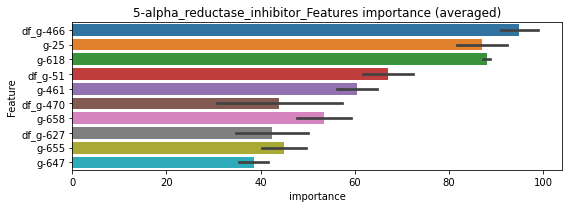

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158613	valid_1's binary_logloss: 0.0221789
[200]	training's binary_logloss: 0.00191749	valid_1's binary_logloss: 0.00464884
[300]	training's binary_logloss: 0.00055544	valid_1's binary_logloss: 0.00253263
[400]	training's binary_logloss: 0.000310243	valid_1's binary_logloss: 0.00217084
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000265255	valid_1's binary_logloss: 0.00211293


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158418	valid_1's binary_logloss: 0.0294679
[200]	training's binary_logloss: 0.00189512	valid_1's binary_logloss: 0.0103182
[300]	training's binary_logloss: 0.000544644	valid_1's binary_logloss: 0.00739448
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.000373546	valid_1's binary_logloss: 0.00705668


5-alpha_reductase_inhibitor logloss: 0.004584805668913884
11-beta-hsd1_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0630963	valid_1's binary_logloss: 0.0978714
[200]	training's binary_logloss: 0.0101347	valid_1's binary_logloss: 0.0269094
[300]	training's binary_logloss: 0.00322338	valid_1's binary_logloss: 0.0127009
[400]	training's binary_logloss: 0.00177195	valid_1's binary_logloss: 0.00893877
[500]	training's binary_logloss: 0.00135497	valid_1's binary_logloss: 0.00759292
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.0012908	valid_1's binary_logloss: 0.00731559
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0603183	valid_1's binary_logloss: 0.118393
[200]	training's binary_logloss: 0.00970117	valid_1's binary_logloss: 0.0412228
[300]	training's binary_logloss: 0.00311734	valid_1's binary_logloss: 0.0214582
[400]	training's binary_logloss: 0.00174065	valid_1's binary_logloss: 0.014622
[500]	training's binary_logloss: 0.00133073	va

1 / 3 AUC score:1.000
Threshold: 0.5306373591142854
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentail: 0.00225
p_label_rate: 0.00000 Vs.target_rate: 0.00083, Num_p_label: 0.0, conf_0:0.00225, conf_1:0.53064
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_1: 0.53
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_2: 0.49
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_3: 0.45
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_4: 0.41
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_5: 0.37
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_6: 0.33
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_7: 0.29
Num_p_label: 2.0, Expected: 3.3, Adj_threshold_8: 0.25
Num_p_label: 6.0, Expected: 3.3, Adj_threshold_9: 0.21
threshold:0.21, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0630963	valid_1's binary_logloss: 0.0978714
[200]	training's binary_logloss: 0.0101347	valid_1's binary_logloss: 0.0269094
[300]	training's binary_logloss: 0.00322338	valid_1's binary_logloss: 0.0127009
[400]	training's binary_logloss: 0.00177195	valid_1's binary_logloss: 0.00893877
[500]	training's binary_logloss: 0.00135497	valid_1's binary_logloss: 0.00759292
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.0012908	valid_1's binary_logloss: 0.00731559
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0603183	valid_1's binary_logloss: 0.118393
[200]	training's binary_logloss: 0.00970117	valid_1's binary_logloss: 0.0412228
[300]	training's binary_logloss: 0.00311734	valid_1's binary_logloss: 0.0214582
[400]	training's binary_logloss: 0.00174065	valid_1's binary_logloss: 0.014622
[500]	training's binary_logloss: 0.00133073	va

2 / 3 AUC score:1.000
Threshold: 0.21063735911428558
Remove_noisy_labels: 4 → positive_corect_labels: 500.0/996
30th percentail: 0.00225
p_label_rate: 0.00151 Vs.target_rate: 0.00083, Num_p_label: 6.0, conf_0:0.00225, conf_1:0.26560
threshold:0.21, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:500.0/996, y_label_rate: 0.50201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0603737	valid_1's binary_logloss: 0.103102
[200]	training's binary_logloss: 0.00972103	valid_1's binary_logloss: 0.0309274
[300]	training's binary_logloss: 0.00314649	valid_1's binary_logloss: 0.0148031
[400]	training's binary_logloss: 0.00174775	valid_1's binary_logloss: 0.00998981
[500]	training's binary_logloss: 0.00136083	valid_1's binary_logloss: 0.00842442
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.00130832	valid_1's binary_logloss: 0.00816067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0625238	valid_1's binary_logloss: 0.103826
[200]	training's binary_logloss: 0.0101086	valid_1's binary_logloss: 0.030314
[300]	training's binary_logloss: 0.00324227	valid_1's binary_logloss: 0.0140103
[400]	training's binary_logloss: 0.00178249	valid_1's binary_logloss: 0.00934894
[500]	training's binary_logloss: 0.00135251	v

3 / 3 AUC score:1.000
Threshold: 0.21063735911428558
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/995
30th percentail: 0.00246
p_label_rate: 0.00226 Vs.target_rate: 0.00083, Num_p_label: 9.0, conf_0:0.00246, conf_1:0.28741
threshold:0.21, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:509.0/4977, y_label_rate: 0.10227


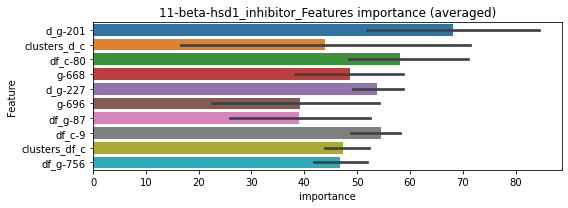

len(train_index) : 2488
len(valid_index) : 2489
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163145	valid_1's binary_logloss: 0.0280404
[200]	training's binary_logloss: 0.00203565	valid_1's binary_logloss: 0.0123373
[300]	training's binary_logloss: 0.000583131	valid_1's binary_logloss: 0.010558
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000557821	valid_1's binary_logloss: 0.0105028


len(train_index) : 2489
len(valid_index) : 2488
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163874	valid_1's binary_logloss: 0.0271309
[200]	training's binary_logloss: 0.00196418	valid_1's binary_logloss: 0.0131605
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.000628554	valid_1's binary_logloss: 0.0121914


11-beta-hsd1_inhibitor logloss: 0.011346919187360537
acat_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0753008	valid_1's binary_logloss: 0.125057
[200]	training's binary_logloss: 0.0135074	valid_1's binary_logloss: 0.0396093
[300]	training's binary_logloss: 0.00429562	valid_1's binary_logloss: 0.0206746
[400]	training's binary_logloss: 0.00224618	valid_1's binary_logloss: 0.0148243
[500]	training's binary_logloss: 0.00157916	valid_1's binary_logloss: 0.0120619
[600]	training's binary_logloss: 0.00140595	valid_1's binary_logloss: 0.0111776
Early stopping, best iteration is:
[612]	training's binary_logloss: 0.00138984	valid_1's binary_logloss: 0.0109923
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0700133	valid_1's binary_logloss: 0.125702
[200]	training's binary_logloss: 0.0125817	valid_1's binary_logloss: 0.0439527
[300]	training's binary_logloss: 0.0040662	valid_1's binary_logloss: 0.0237311
[400]	training's binary_logloss: 0.00216464	valid_

1 / 3 AUC score:1.000
Threshold: 0.48230207207171244
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
30th percentail: 0.00297
p_label_rate: 0.00000 Vs.target_rate: 0.00111, Num_p_label: 0.0, conf_0:0.00297, conf_1:0.48230
Num_p_label: 0.0, Expected: 4.4, Adj_threshold_1: 0.48
Num_p_label: 0.0, Expected: 4.4, Adj_threshold_2: 0.44
Num_p_label: 1.0, Expected: 4.4, Adj_threshold_3: 0.40
Num_p_label: 1.0, Expected: 4.4, Adj_threshold_4: 0.36
Num_p_label: 5.0, Expected: 4.4, Adj_threshold_5: 0.32
threshold:0.32, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0706988	valid_1's binary_logloss: 0.120044
[200]	training's binary_logloss: 0.0125632	valid_1's binary_logloss: 0.0372323
[300]	training's binary_logloss: 0.00401928	valid_1's binary_logloss: 0.0186887
[400]	training's binary_logloss: 0.00216565	valid_1's binary_logloss: 0.0133144
[500]	training's binary_logloss: 0.00155567	valid_1's binary_logloss: 0.0112177
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00140685	valid_1's binary_logloss: 0.0104797
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.070787	valid_1's binary_logloss: 0.117427
[200]	training's binary_logloss: 0.0126173	valid_1's binary_logloss: 0.0384294
[300]	training's binary_logloss: 0.00406469	valid_1's binary_logloss: 0.0202271
[400]	training's binary_logloss: 0.0022023	valid_1's binary_logloss: 0.0149143
[500]	training's binary_logloss: 0.00156839	valid_1

2 / 3 AUC score:1.000
Threshold: 0.3223020720717125
Remove_noisy_labels: 1 → positive_corect_labels: 499.0/997
30th percentail: 0.00329
p_label_rate: 0.00075 Vs.target_rate: 0.00111, Num_p_label: 3.0, conf_0:0.00329, conf_1:0.35384
threshold:0.32, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:499.0/997, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0722619	valid_1's binary_logloss: 0.127959
[200]	training's binary_logloss: 0.0127148	valid_1's binary_logloss: 0.0423722
[300]	training's binary_logloss: 0.00407729	valid_1's binary_logloss: 0.0221076
[400]	training's binary_logloss: 0.00216515	valid_1's binary_logloss: 0.0161936
[500]	training's binary_logloss: 0.00154146	valid_1's binary_logloss: 0.0134424
[600]	training's binary_logloss: 0.00138952	valid_1's binary_logloss: 0.0125193
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00138952	valid_1's binary_logloss: 0.0125193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0705185	valid_1's binary_logloss: 0.113585
[200]	training's binary_logloss: 0.0127765	valid_1's binary_logloss: 0.0356983
[300]	training's binary_logloss: 0.00408484	valid_1's binary_logloss: 0.018391
[400]	training's binary_logloss: 0.00220014	valid_

3 / 3 AUC score:1.000
Threshold: 0.3223020720717125
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/997
30th percentail: 0.00313
p_label_rate: 0.00050 Vs.target_rate: 0.00111, Num_p_label: 2.0, conf_0:0.00313, conf_1:0.32230
threshold:0.32, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:501.0/4979, y_label_rate: 0.10062


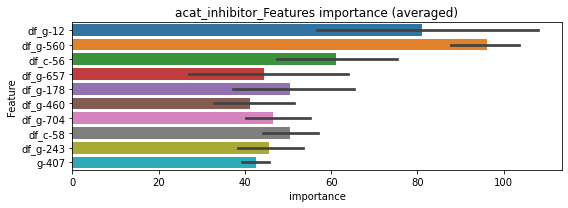

len(train_index) : 2489
len(valid_index) : 2490
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192057	valid_1's binary_logloss: 0.0305974
[200]	training's binary_logloss: 0.0024435	valid_1's binary_logloss: 0.00731917
[300]	training's binary_logloss: 0.000681258	valid_1's binary_logloss: 0.00394914
[400]	training's binary_logloss: 0.000356545	valid_1's binary_logloss: 0.003292
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000364891	valid_1's binary_logloss: 0.00326823


len(train_index) : 2490
len(valid_index) : 2489
================================= fold 2/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188306	valid_1's binary_logloss: 0.0358552
[200]	training's binary_logloss: 0.00240495	valid_1's binary_logloss: 0.0144968
[300]	training's binary_logloss: 0.00066743	valid_1's binary_logloss: 0.0109679
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.000594221	valid_1's binary_logloss: 0.0107573


acat_inhibitor logloss: 0.007011992739043723
acetylcholine_receptor_agonist , len(trt) : 190
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182699	valid_1's binary_logloss: 0.480119
[200]	training's binary_logloss: 0.0637497	valid_1's binary_logloss: 0.409664
[300]	training's binary_logloss: 0.0254878	valid_1's binary_logloss: 0.381151
[400]	training's binary_logloss: 0.0123577	valid_1's binary_logloss: 0.364855
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.0121227	valid_1's binary_logloss: 0.364464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194266	valid_1's binary_logloss: 0.481761
[200]	training's binary_logloss: 0.0670598	valid_1's binary_logloss: 0.421659


1 / 3 AUC score:0.900
Threshold: 0.47792192644906295
Remove_noisy_labels: 182 → positive_corect_labels: 409/818
30th percentail: 0.22248
p_label_rate: 0.14239 Vs.target_rate: 0.00878, Num_p_label: 567.0, conf_0:0.22248, conf_1:0.50289
Num_p_label: 567.0, Expected: 34.9, Adj_threshold_1: 0.48
Num_p_label: 386.0, Expected: 34.9, Adj_threshold_2: 0.52
Num_p_label: 257.0, Expected: 34.9, Adj_threshold_3: 0.56
Num_p_label: 154.0, Expected: 34.9, Adj_threshold_4: 0.60


Early stopping, best iteration is:
[229]	training's binary_logloss: 0.0504414	valid_1's binary_logloss: 0.40875


Num_p_label: 84.0, Expected: 34.9, Adj_threshold_5: 0.64
Num_p_label: 50.0, Expected: 34.9, Adj_threshold_6: 0.68
threshold:0.68, positive p_label:50.0/3982, p_label_rate: 0.01256
positive y_label:409.0/818, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162419	valid_1's binary_logloss: 0.428844
[200]	training's binary_logloss: 0.051184	valid_1's binary_logloss: 0.350605
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0364708	valid_1's binary_logloss: 0.33786
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171483	valid_1's binary_logloss: 0.402756
[200]	training's binary_logloss: 0.0557336	valid_1's binary_logloss: 0.303144
[300]	training's binary_logloss: 0.0220526	valid_1's binary_logloss: 0.260016
[400]	training's binary_logloss: 0.0108729	valid_1's binary_logloss: 0.235441
[500]	training's binary_logloss: 0.00655688	valid_1's binary_logloss: 0.222455
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00642074	valid_1's binary_logloss: 0.222029


2 / 3 AUC score:0.956
Threshold: 0.6779219264490631
Remove_noisy_labels: 98 → positive_corect_labels: 319.0/720
30th percentail: 0.15032
p_label_rate: 0.02511 Vs.target_rate: 0.00878, Num_p_label: 100.0, conf_0:0.15032, conf_1:0.67792
threshold:0.68, positive p_label:100.0/3982, p_label_rate: 0.02511
positive y_label:319.0/720, y_label_rate: 0.44306
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147776	valid_1's binary_logloss: 0.373481
[200]	training's binary_logloss: 0.04428	valid_1's binary_logloss: 0.280331
[300]	training's binary_logloss: 0.0172571	valid_1's binary_logloss: 0.250394
[400]	training's binary_logloss: 0.00852301	valid_1's binary_logloss: 0.235664
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00758836	valid_1's binary_logloss: 0.233567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154474	valid_1's binary_logloss: 0.355086
[200]	training's binary_logloss: 0.0483501	valid_1's binary_logloss: 0.250119
[300]	training's binary_logloss: 0.0186859	valid_1's binary_logloss: 0.205177


3 / 3 AUC score:0.970
Threshold: 0.6779219264490631
Remove_noisy_labels: 58 → positive_corect_labels: 266.0/662


Early stopping, best iteration is:
[362]	training's binary_logloss: 0.0116917	valid_1's binary_logloss: 0.194855


30th percentail: 0.07747
p_label_rate: 0.01281 Vs.target_rate: 0.00878, Num_p_label: 51.0, conf_0:0.07747, conf_1:0.67792
threshold:0.68, positive p_label:51.0/3982, p_label_rate: 0.01281
positive y_label:317.0/4644, y_label_rate: 0.06826


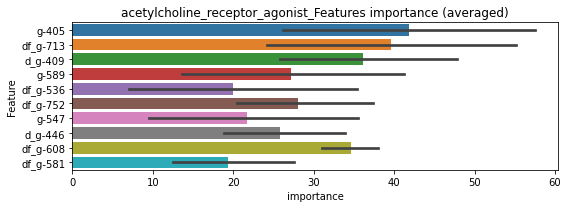

len(train_index) : 2322
len(valid_index) : 2322
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328195	valid_1's binary_logloss: 0.126531
[200]	training's binary_logloss: 0.00757372	valid_1's binary_logloss: 0.11346
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.00587306	valid_1's binary_logloss: 0.112917


len(train_index) : 2322
len(valid_index) : 2322
================================= fold 2/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333779	valid_1's binary_logloss: 0.134608


acetylcholine_receptor_agonist logloss: 0.12030566857414945


Early stopping, best iteration is:
[181]	training's binary_logloss: 0.00975309	valid_1's binary_logloss: 0.127695


acetylcholine_receptor_antagonist , len(trt) : 301
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210717	valid_1's binary_logloss: 0.600581
Early stopping, best iteration is:
[162]	training's binary_logloss: 0.111948	valid_1's binary_logloss: 0.578406
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203497	valid_1's binary_logloss: 0.609115


1 / 3 AUC score:0.748
Threshold: 0.49150286939274523
Remove_noisy_labels: 316 → positive_corect_labels: 342/684
30th percentail: 0.36458
p_label_rate: 0.29382 Vs.target_rate: 0.01390, Num_p_label: 1170.0, conf_0:0.36458, conf_1:0.49650
Num_p_label: 1170.0, Expected: 55.4, Adj_threshold_1: 0.49
Num_p_label: 788.0, Expected: 55.4, Adj_threshold_2: 0.53


Early stopping, best iteration is:
[184]	training's binary_logloss: 0.088408	valid_1's binary_logloss: 0.58278


Num_p_label: 480.0, Expected: 55.4, Adj_threshold_3: 0.57
Num_p_label: 267.0, Expected: 55.4, Adj_threshold_4: 0.61
Num_p_label: 130.0, Expected: 55.4, Adj_threshold_5: 0.65
Num_p_label: 60.0, Expected: 55.4, Adj_threshold_6: 0.69
threshold:0.69, positive p_label:60.0/3982, p_label_rate: 0.01507
positive y_label:342.0/684, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.188397	valid_1's binary_logloss: 0.512122
[200]	training's binary_logloss: 0.0666114	valid_1's binary_logloss: 0.442003
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.0311354	valid_1's binary_logloss: 0.420502
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190983	valid_1's binary_logloss: 0.492667
[200]	training's binary_logloss: 0.0681381	valid_1's binary_logloss: 0.425895
[300]	training's binary_logloss: 0.0283361	valid_1's binary_logloss: 0.398855


2 / 3 AUC score:0.897
Threshold: 0.6915028693927454
Remove_noisy_labels: 131 → positive_corect_labels: 232.0/553


Early stopping, best iteration is:
[366]	training's binary_logloss: 0.0174862	valid_1's binary_logloss: 0.38506


30th percentail: 0.27196
p_label_rate: 0.11401 Vs.target_rate: 0.01390, Num_p_label: 454.0, conf_0:0.27196, conf_1:0.69150
Num_p_label: 454.0, Expected: 55.4, Adj_threshold_1: 0.69
Num_p_label: 341.0, Expected: 55.4, Adj_threshold_2: 0.73
Num_p_label: 248.0, Expected: 55.4, Adj_threshold_3: 0.77
Num_p_label: 167.0, Expected: 55.4, Adj_threshold_4: 0.81
Num_p_label: 109.0, Expected: 55.4, Adj_threshold_5: 0.85
Num_p_label: 66.0, Expected: 55.4, Adj_threshold_6: 0.89
threshold:0.89, positive p_label:66.0/3982, p_label_rate: 0.01657
positive y_label:232.0/553, y_label_rate: 0.41953
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172202	valid_1's binary_logloss: 0.447137
[200]	training's binary_logloss: 0.0557745	valid_1's binary_logloss: 0.364474
[300]	training's binary_logloss: 0.0228076	valid_1's binary_logloss: 0.329361
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0239078	valid_1's binary_logloss: 0.327211
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175214	valid_1's binary_logloss: 0.438168
[200]	training's binary_logloss: 0.0592492	valid_1's binary_logloss: 0.352845
[300]	training's binary_logloss: 0.0239604	valid_1's binary_logloss: 0.313437
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0213194	valid_1's binary_logloss: 0.308641


3 / 3 AUC score:0.934
Threshold: 0.8915028693927456
Remove_noisy_labels: 113 → positive_corect_labels: 119.0/440
30th percentail: 0.14010
p_label_rate: 0.01406 Vs.target_rate: 0.01390, Num_p_label: 56.0, conf_0:0.14010, conf_1:0.89150
threshold:0.89, positive p_label:56.0/3982, p_label_rate: 0.01406
positive y_label:175.0/4422, y_label_rate: 0.03957


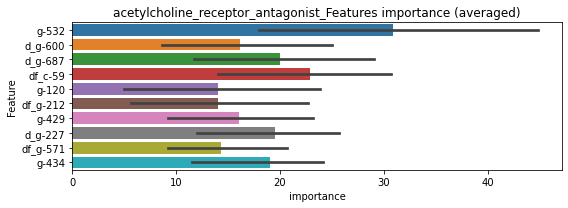

len(train_index) : 2211
len(valid_index) : 2211
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129586	valid_1's binary_logloss: 0.0877441


len(train_index) : 2211
len(valid_index) : 2211
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Early stopping, best iteration is:
[129]	training's binary_logloss: 0.00765937	valid_1's binary_logloss: 0.0866018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128213	valid_1's binary_logloss: 0.0933516


acetylcholine_receptor_antagonist logloss: 0.08987206144450333
acetylcholinesterase_inhibitor , len(trt) : 73


Early stopping, best iteration is:
[103]	training's binary_logloss: 0.0121104	valid_1's binary_logloss: 0.0931424


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129439	valid_1's binary_logloss: 0.299751
[200]	training's binary_logloss: 0.034514	valid_1's binary_logloss: 0.188502
[300]	training's binary_logloss: 0.0121071	valid_1's binary_logloss: 0.148811
[400]	training's binary_logloss: 0.0059271	valid_1's binary_logloss: 0.136396
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00404899	valid_1's binary_logloss: 0.127569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126606	valid_1's binary_logloss: 0.28451
[200]	training's binary_logloss: 0.0350064	valid_1's binary_logloss: 0.185558
[300]	training's binary_logloss: 0.0122225	valid_1's binary_logloss: 0.141292
[400]	training's binary_logloss: 0.00591787	valid_1's binary_logloss: 0.122134
[500]	training's binary_logloss: 0.00367407	valid_1's binary_logloss: 0.111815
Early stopping, best iteration is:
[582]	training's binary_loglo

1 / 3 AUC score:0.992
Threshold: 0.3990290812929945
Remove_noisy_labels: 42 → positive_corect_labels: 479/958
30th percentail: 0.03004
p_label_rate: 0.02637 Vs.target_rate: 0.00337, Num_p_label: 105.0, conf_0:0.02531, conf_1:0.46062
Num_p_label: 105.0, Expected: 13.4, Adj_threshold_1: 0.40
Num_p_label: 71.0, Expected: 13.4, Adj_threshold_2: 0.44
Num_p_label: 39.0, Expected: 13.4, Adj_threshold_3: 0.48
Num_p_label: 21.0, Expected: 13.4, Adj_threshold_4: 0.52
Num_p_label: 15.0, Expected: 13.4, Adj_threshold_5: 0.56
threshold:0.56, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:479.0/958, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130487	valid_1's binary_logloss: 0.270746
[200]	training's binary_logloss: 0.0337829	valid_1's binary_logloss: 0.155496
[300]	training's binary_logloss: 0.0118137	valid_1's binary_logloss: 0.111911
[400]	training's binary_logloss: 0.00577481	valid_1's binary_logloss: 0.0926049
[500]	training's binary_logloss: 0.00363972	valid_1's binary_logloss: 0.0824854
[600]	training's binary_logloss: 0.00267296	valid_1's binary_logloss: 0.0763103
Early stopping, best iteration is:
[626]	training's binary_logloss: 0.0025302	valid_1's binary_logloss: 0.0755196
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126995	valid_1's binary_logloss: 0.276426
[200]	training's binary_logloss: 0.0338129	valid_1's binary_logloss: 0.163784
[300]	training's binary_logloss: 0.0117738	valid_1's binary_logloss: 0.122646
[400]	training's binary_logloss: 0.00566846	valid_1's bina

2 / 3 AUC score:0.998
Threshold: 0.5590290812929946
Remove_noisy_labels: 22 → positive_corect_labels: 461.0/936
30th percentail: 0.02217
p_label_rate: 0.00703 Vs.target_rate: 0.00337, Num_p_label: 28.0, conf_0:0.01205, conf_1:0.55903
threshold:0.56, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:461.0/936, y_label_rate: 0.49252
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12139	valid_1's binary_logloss: 0.271259
[200]	training's binary_logloss: 0.0318719	valid_1's binary_logloss: 0.171875
[300]	training's binary_logloss: 0.0111675	valid_1's binary_logloss: 0.133478
[400]	training's binary_logloss: 0.00542039	valid_1's binary_logloss: 0.115461
[500]	training's binary_logloss: 0.00345815	valid_1's binary_logloss: 0.104543
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00297712	valid_1's binary_logloss: 0.10206
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123032	valid_1's binary_logloss: 0.274316
[200]	training's binary_logloss: 0.0316873	valid_1's binary_logloss: 0.169696
[300]	training's binary_logloss: 0.0109129	valid_1's binary_logloss: 0.125451
[400]	training's binary_logloss: 0.00536767	valid_1's binary_logloss: 0.110779
[500]	training's binary_logloss: 0.00341809	valid_1's binary_lo

3 / 3 AUC score:0.994
Threshold: 0.5590290812929946
Remove_noisy_labels: 30 → positive_corect_labels: 433.0/906
30th percentail: 0.02122
p_label_rate: 0.00779 Vs.target_rate: 0.00337, Num_p_label: 31.0, conf_0:0.01108, conf_1:0.55903
threshold:0.56, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:464.0/4888, y_label_rate: 0.09493


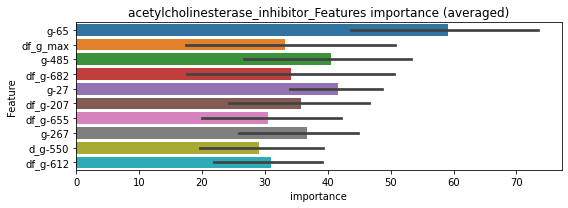

len(train_index) : 2444
len(valid_index) : 2444
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337867	valid_1's binary_logloss: 0.0844254
[200]	training's binary_logloss: 0.00659573	valid_1's binary_logloss: 0.0577162
[300]	training's binary_logloss: 0.00197223	valid_1's binary_logloss: 0.0532537
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0021759	valid_1's binary_logloss: 0.0529826


len(train_index) : 2444
len(valid_index) : 2444
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342785	valid_1's binary_logloss: 0.0855671
[200]	training's binary_logloss: 0.00663731	valid_1's binary_logloss: 0.0604736
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00275761	valid_1's binary_logloss: 0.0572637


acetylcholinesterase_inhibitor logloss: 0.055123146186090946
adenosine_receptor_agonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112274	valid_1's binary_logloss: 0.226618
[200]	training's binary_logloss: 0.0276538	valid_1's binary_logloss: 0.121587
[300]	training's binary_logloss: 0.00948373	valid_1's binary_logloss: 0.0830754
[400]	training's binary_logloss: 0.00467473	valid_1's binary_logloss: 0.0690784
[500]	training's binary_logloss: 0.00300477	valid_1's binary_logloss: 0.0626621
[600]	training's binary_logloss: 0.00227619	valid_1's binary_logloss: 0.0588996
[700]	training's binary_logloss: 0.00195517	valid_1's binary_logloss: 0.0569108
Early stopping, best iteration is:
[754]	training's binary_logloss: 0.00189884	valid_1's binary_logloss: 0.0565288
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112207	valid_1's binary_logloss: 0.233968
[200]	training's binary_logloss: 0.0276435	valid_1's binary_logloss: 0.13291
[300]	training's binary_logloss: 0.00956477	valid_1's 

1 / 3 AUC score:0.998
Threshold: 0.398027708916293
Remove_noisy_labels: 20 → positive_corect_labels: 490/980
30th percentail: 0.01666
p_label_rate: 0.01180 Vs.target_rate: 0.00249, Num_p_label: 47.0, conf_0:0.01666, conf_1:0.48205
Num_p_label: 47.0, Expected: 9.9, Adj_threshold_1: 0.40
Num_p_label: 29.0, Expected: 9.9, Adj_threshold_2: 0.44
Num_p_label: 16.0, Expected: 9.9, Adj_threshold_3: 0.48
Num_p_label: 10.0, Expected: 9.9, Adj_threshold_4: 0.52
threshold:0.52, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:490.0/980, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107092	valid_1's binary_logloss: 0.225875
[200]	training's binary_logloss: 0.0253415	valid_1's binary_logloss: 0.122477
[300]	training's binary_logloss: 0.00878671	valid_1's binary_logloss: 0.087552
[400]	training's binary_logloss: 0.00444835	valid_1's binary_logloss: 0.0731954
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00307512	valid_1's binary_logloss: 0.0680437
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111442	valid_1's binary_logloss: 0.228677
[200]	training's binary_logloss: 0.027037	valid_1's binary_logloss: 0.118217
[300]	training's binary_logloss: 0.00926061	valid_1's binary_logloss: 0.0780395
[400]	training's binary_logloss: 0.00460847	valid_1's binary_logloss: 0.0617159
[500]	training's binary_logloss: 0.00293184	valid_1's binary_logloss: 0.0536977
[600]	training's binary_logloss: 0.0022527	valid_1's bi

2 / 3 AUC score:0.999
Threshold: 0.518027708916293
Remove_noisy_labels: 14 → positive_corect_labels: 478.0/966
30th percentail: 0.01648
p_label_rate: 0.00502 Vs.target_rate: 0.00249, Num_p_label: 20.0, conf_0:0.01648, conf_1:0.51803
threshold:0.52, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:478.0/966, y_label_rate: 0.49482
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107574	valid_1's binary_logloss: 0.229717
[200]	training's binary_logloss: 0.0254611	valid_1's binary_logloss: 0.116444
[300]	training's binary_logloss: 0.00861845	valid_1's binary_logloss: 0.0757621
[400]	training's binary_logloss: 0.0043438	valid_1's binary_logloss: 0.0592741
[500]	training's binary_logloss: 0.00283249	valid_1's binary_logloss: 0.0521747
[600]	training's binary_logloss: 0.00218201	valid_1's binary_logloss: 0.0481745
Early stopping, best iteration is:
[676]	training's binary_logloss: 0.00198466	valid_1's binary_logloss: 0.0469435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110393	valid_1's binary_logloss: 0.228003
[200]	training's binary_logloss: 0.0267289	valid_1's binary_logloss: 0.112012
[300]	training's binary_logloss: 0.00906751	valid_1's binary_logloss: 0.0711913
[400]	training's binary_logloss: 0.00454244	valid_1's 

3 / 3 AUC score:1.000
Threshold: 0.518027708916293
Remove_noisy_labels: 7 → positive_corect_labels: 473.0/959
30th percentail: 0.01256
p_label_rate: 0.00527 Vs.target_rate: 0.00249, Num_p_label: 21.0, conf_0:0.01256, conf_1:0.51803
threshold:0.52, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:494.0/4941, y_label_rate: 0.09998


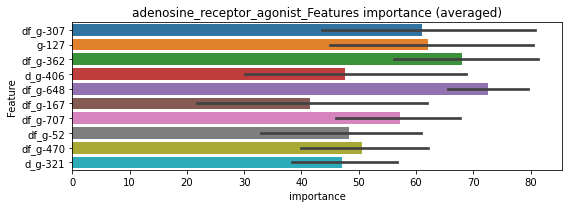

len(train_index) : 2470
len(valid_index) : 2471
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316621	valid_1's binary_logloss: 0.0672347
[200]	training's binary_logloss: 0.00586696	valid_1's binary_logloss: 0.0369624
[300]	training's binary_logloss: 0.00168316	valid_1's binary_logloss: 0.0316649
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000934645	valid_1's binary_logloss: 0.0308692


len(train_index) : 2471
len(valid_index) : 2470
================================= fold 2/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290522	valid_1's binary_logloss: 0.0716134
[200]	training's binary_logloss: 0.00516279	valid_1's binary_logloss: 0.0419688
[300]	training's binary_logloss: 0.00157555	valid_1's binary_logloss: 0.0359602
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00135636	valid_1's binary_logloss: 0.0354255


adenosine_receptor_agonist logloss: 0.03314689109569592
adenosine_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143902	valid_1's binary_logloss: 0.334491
[200]	training's binary_logloss: 0.0417254	valid_1's binary_logloss: 0.246995
[300]	training's binary_logloss: 0.0151441	valid_1's binary_logloss: 0.202925
[400]	training's binary_logloss: 0.00736577	valid_1's binary_logloss: 0.186719
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00581368	valid_1's binary_logloss: 0.181125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140599	valid_1's binary_logloss: 0.323715
[200]	training's binary_logloss: 0.040699	valid_1's binary_logloss: 0.233218
[300]	training's binary_logloss: 0.0149075	valid_1's binary_logloss: 0.194665
[400]	training's binary_logloss: 0.00726318	valid_1's binary_logloss: 0.177036
[500]	training's binary_logloss: 0.00447872	valid_1's binary_logloss: 0.168673
[600]	training's binary_logloss: 0.00327773	valid_1's binary_l

1 / 3 AUC score:0.978
Threshold: 0.40746636942188974
Remove_noisy_labels: 64 → positive_corect_labels: 468/936
30th percentail: 0.05235
p_label_rate: 0.04520 Vs.target_rate: 0.00443, Num_p_label: 180.0, conf_0:0.05235, conf_1:0.57045
Num_p_label: 180.0, Expected: 17.7, Adj_threshold_1: 0.41
Num_p_label: 126.0, Expected: 17.7, Adj_threshold_2: 0.45
Num_p_label: 84.0, Expected: 17.7, Adj_threshold_3: 0.49
Num_p_label: 55.0, Expected: 17.7, Adj_threshold_4: 0.53
Num_p_label: 36.0, Expected: 17.7, Adj_threshold_5: 0.57
Num_p_label: 26.0, Expected: 17.7, Adj_threshold_6: 0.61
threshold:0.61, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:468.0/936, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126568	valid_1's binary_logloss: 0.293238
[200]	training's binary_logloss: 0.0358439	valid_1's binary_logloss: 0.200941
[300]	training's binary_logloss: 0.0130279	valid_1's binary_logloss: 0.166641
[400]	training's binary_logloss: 0.00635556	valid_1's binary_logloss: 0.155009
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00591525	valid_1's binary_logloss: 0.15323
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134666	valid_1's binary_logloss: 0.315672
[200]	training's binary_logloss: 0.0372213	valid_1's binary_logloss: 0.216347
[300]	training's binary_logloss: 0.0133554	valid_1's binary_logloss: 0.173856
[400]	training's binary_logloss: 0.00652005	valid_1's binary_logloss: 0.15553
[500]	training's binary_logloss: 0.00411812	valid_1's binary_logloss: 0.146982
Early stopping, best iteration is:
[560]	training's binary_logl

2 / 3 AUC score:0.987
Threshold: 0.6074663694218898
Remove_noisy_labels: 52 → positive_corect_labels: 427.0/884
30th percentail: 0.03744
p_label_rate: 0.01256 Vs.target_rate: 0.00443, Num_p_label: 50.0, conf_0:0.03744, conf_1:0.60747
threshold:0.61, positive p_label:50.0/3982, p_label_rate: 0.01256
positive y_label:427.0/884, y_label_rate: 0.48303
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123247	valid_1's binary_logloss: 0.266499
[200]	training's binary_logloss: 0.0334546	valid_1's binary_logloss: 0.164066
[300]	training's binary_logloss: 0.0119246	valid_1's binary_logloss: 0.126057
[400]	training's binary_logloss: 0.00595957	valid_1's binary_logloss: 0.111528
[500]	training's binary_logloss: 0.00380782	valid_1's binary_logloss: 0.104829
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00380782	valid_1's binary_logloss: 0.104829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121475	valid_1's binary_logloss: 0.284335
[200]	training's binary_logloss: 0.0325503	valid_1's binary_logloss: 0.181033
[300]	training's binary_logloss: 0.011847	valid_1's binary_logloss: 0.146041
[400]	training's binary_logloss: 0.00593094	valid_1's binary_logloss: 0.133542
Early stopping, best iteration is:
[442]	training's binary_log

3 / 3 AUC score:0.990
Threshold: 0.6074663694218898
Remove_noisy_labels: 33 → positive_corect_labels: 398.0/851
30th percentail: 0.02772
p_label_rate: 0.01431 Vs.target_rate: 0.00443, Num_p_label: 57.0, conf_0:0.02772, conf_1:0.60747
Num_p_label: 57.0, Expected: 17.7, Adj_threshold_1: 0.61
Num_p_label: 38.0, Expected: 17.7, Adj_threshold_2: 0.65
Num_p_label: 31.0, Expected: 17.7, Adj_threshold_3: 0.69
Num_p_label: 14.0, Expected: 17.7, Adj_threshold_4: 0.73
threshold:0.73, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:412.0/4833, y_label_rate: 0.08525


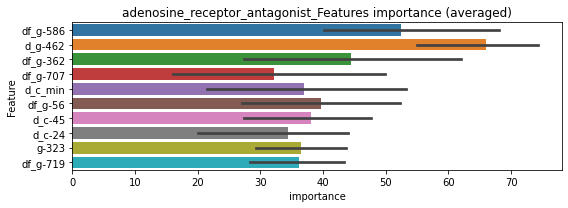

len(train_index) : 2416
len(valid_index) : 2417
================================= fold 1/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293323	valid_1's binary_logloss: 0.0826748
[200]	training's binary_logloss: 0.00590701	valid_1's binary_logloss: 0.0586387
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.00358584	valid_1's binary_logloss: 0.0562179


len(train_index) : 2417
len(valid_index) : 2416
================================= fold 2/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281712	valid_1's binary_logloss: 0.0756328
[200]	training's binary_logloss: 0.00561135	valid_1's binary_logloss: 0.0524328
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0032706	valid_1's binary_logloss: 0.0502175


adenosine_receptor_antagonist logloss: 0.05321831574252732
adenylyl_cyclase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0626565	valid_1's binary_logloss: 0.0975469
[200]	training's binary_logloss: 0.010082	valid_1's binary_logloss: 0.0286012
[300]	training's binary_logloss: 0.00318289	valid_1's binary_logloss: 0.0141237
[400]	training's binary_logloss: 0.00174545	valid_1's binary_logloss: 0.0100921
[500]	training's binary_logloss: 0.00130679	valid_1's binary_logloss: 0.00839523
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00121891	valid_1's binary_logloss: 0.00785089
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0611542	valid_1's binary_logloss: 0.103168
[200]	training's binary_logloss: 0.00974273	valid_1's binary_logloss: 0.0347576
[300]	training's binary_logloss: 0.00307298	valid_1's binary_logloss: 0.0205607
[400]	training's binary_logloss: 0.00172401	valid_1's binary_logloss: 0.0155403
[500]	training's binary_logloss: 0.00128608	va

1 / 3 AUC score:1.000
Threshold: 0.4338382652683694
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentail: 0.00158
p_label_rate: 0.00100 Vs.target_rate: 0.00083, Num_p_label: 4.0, conf_0:0.00158, conf_1:0.45062
threshold:0.43, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0626565	valid_1's binary_logloss: 0.0975469
[200]	training's binary_logloss: 0.010082	valid_1's binary_logloss: 0.0286012
[300]	training's binary_logloss: 0.00318289	valid_1's binary_logloss: 0.0141237
[400]	training's binary_logloss: 0.00174545	valid_1's binary_logloss: 0.0100921
[500]	training's binary_logloss: 0.00130679	valid_1's binary_logloss: 0.00839523
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00121891	valid_1's binary_logloss: 0.00785089
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0611542	valid_1's binary_logloss: 0.103168
[200]	training's binary_logloss: 0.00974273	valid_1's binary_logloss: 0.0347576
[300]	training's binary_logloss: 0.00307298	valid_1's binary_logloss: 0.0205607
[400]	training's binary_logloss: 0.00172401	valid_1's binary_logloss: 0.0155403
[500]	training's binary_logloss: 0.00128608	va

2 / 3 AUC score:1.000
Threshold: 0.4338382652683694
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentail: 0.00158
p_label_rate: 0.00100 Vs.target_rate: 0.00083, Num_p_label: 4.0, conf_0:0.00158, conf_1:0.45062
threshold:0.43, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0626565	valid_1's binary_logloss: 0.0975469
[200]	training's binary_logloss: 0.010082	valid_1's binary_logloss: 0.0286012
[300]	training's binary_logloss: 0.00318289	valid_1's binary_logloss: 0.0141237
[400]	training's binary_logloss: 0.00174545	valid_1's binary_logloss: 0.0100921
[500]	training's binary_logloss: 0.00130679	valid_1's binary_logloss: 0.00839523
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00121891	valid_1's binary_logloss: 0.00785089
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0611542	valid_1's binary_logloss: 0.103168
[200]	training's binary_logloss: 0.00974273	valid_1's binary_logloss: 0.0347576
[300]	training's binary_logloss: 0.00307298	valid_1's binary_logloss: 0.0205607
[400]	training's binary_logloss: 0.00172401	valid_1's binary_logloss: 0.0155403
[500]	training's binary_logloss: 0.00128608	va

3 / 3 AUC score:1.000
Threshold: 0.4338382652683694
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentail: 0.00158
p_label_rate: 0.00100 Vs.target_rate: 0.00083, Num_p_label: 4.0, conf_0:0.00158, conf_1:0.45062
threshold:0.43, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:504.0/4982, y_label_rate: 0.10116


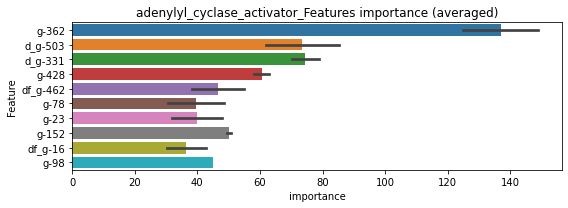

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154817	valid_1's binary_logloss: 0.0250136
[200]	training's binary_logloss: 0.00186809	valid_1's binary_logloss: 0.00648372
[300]	training's binary_logloss: 0.000541099	valid_1's binary_logloss: 0.0037499
[400]	training's binary_logloss: 0.00029415	valid_1's binary_logloss: 0.00322579
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00029415	valid_1's binary_logloss: 0.00322579


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162027	valid_1's binary_logloss: 0.0241854
[200]	training's binary_logloss: 0.00192176	valid_1's binary_logloss: 0.00807925
[300]	training's binary_logloss: 0.000552579	valid_1's binary_logloss: 0.00673649
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.000573459	valid_1's binary_logloss: 0.00672565


adenylyl_cyclase_activator logloss: 0.004975721345092083
adrenergic_receptor_agonist , len(trt) : 270
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.199738	valid_1's binary_logloss: 0.576868
[200]	training's binary_logloss: 0.0730441	valid_1's binary_logloss: 0.549866
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0503974	valid_1's binary_logloss: 0.539799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20499	valid_1's binary_logloss: 0.56452
[200]	training's binary_logloss: 0.0782235	valid_1's binary_logloss: 0.532275


1 / 3 AUC score:0.799
Threshold: 0.48264890520197884
Remove_noisy_labels: 270 → positive_corect_labels: 365/730
30th percentail: 0.32045


Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0510091	valid_1's binary_logloss: 0.519119


p_label_rate: 0.25038 Vs.target_rate: 0.01247, Num_p_label: 997.0, conf_0:0.32045, conf_1:0.49752
Num_p_label: 997.0, Expected: 49.7, Adj_threshold_1: 0.48
Num_p_label: 706.0, Expected: 49.7, Adj_threshold_2: 0.52
Num_p_label: 449.0, Expected: 49.7, Adj_threshold_3: 0.56
Num_p_label: 287.0, Expected: 49.7, Adj_threshold_4: 0.60
Num_p_label: 165.0, Expected: 49.7, Adj_threshold_5: 0.64
Num_p_label: 78.0, Expected: 49.7, Adj_threshold_6: 0.68
Num_p_label: 31.0, Expected: 49.7, Adj_threshold_7: 0.72
threshold:0.72, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:365.0/730, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182896	valid_1's binary_logloss: 0.495134
[200]	training's binary_logloss: 0.0630192	valid_1's binary_logloss: 0.437233
[300]	training's binary_logloss: 0.0253792	valid_1's binary_logloss: 0.415409
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0217162	valid_1's binary_logloss: 0.414133
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181735	valid_1's binary_logloss: 0.490876
[200]	training's binary_logloss: 0.0632673	valid_1's binary_logloss: 0.436638
[300]	training's binary_logloss: 0.0259534	valid_1's binary_logloss: 0.407273
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.0267715	valid_1's binary_logloss: 0.406863


2 / 3 AUC score:0.893
Threshold: 0.722648905201979
Remove_noisy_labels: 144 → positive_corect_labels: 235.0/586
30th percentail: 0.25818
p_label_rate: 0.06328 Vs.target_rate: 0.01247, Num_p_label: 252.0, conf_0:0.25818, conf_1:0.72265
Num_p_label: 252.0, Expected: 49.7, Adj_threshold_1: 0.72
Num_p_label: 176.0, Expected: 49.7, Adj_threshold_2: 0.76
Num_p_label: 108.0, Expected: 49.7, Adj_threshold_3: 0.80
Num_p_label: 63.0, Expected: 49.7, Adj_threshold_4: 0.84
threshold:0.84, positive p_label:63.0/3982, p_label_rate: 0.01582
positive y_label:235.0/586, y_label_rate: 0.40102
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151195	valid_1's binary_logloss: 0.399466
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.062743	valid_1's binary_logloss: 0.35322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153615	valid_1's binary_logloss: 0.396336
[200]	training's binary_logloss: 0.0497574	valid_1's binary_logloss: 0.328242
[300]	training's binary_logloss: 0.0194837	valid_1's binary_logloss: 0.289397


3 / 3 AUC score:0.928
Threshold: 0.8426489052019791
Remove_noisy_labels: 105 → positive_corect_labels: 130.0/481
30th percentail: 0.13234
p_label_rate: 0.01155 Vs.target_rate: 0.01247, Num_p_label: 46.0, conf_0:0.13234, conf_1:0.84265


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.014435	valid_1's binary_logloss: 0.283697


threshold:0.84, positive p_label:46.0/3982, p_label_rate: 0.01155
positive y_label:176.0/4463, y_label_rate: 0.03944


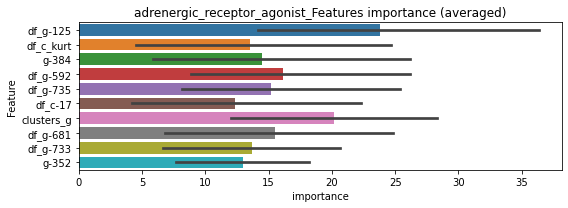

len(train_index) : 2231
len(valid_index) : 2232
================================= fold 1/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2232
len(valid_index) : 2231
================================= fold 2/2 adrenergic_receptor_agonist=================================


Early stopping, best iteration is:
[85]	training's binary_logloss: 0.0191455	valid_1's binary_logloss: 0.0979766
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.014001	valid_1's binary_logloss: 0.101385


adrenergic_receptor_agonist logloss: 0.09957774129534684


Early stopping, best iteration is:
[98]	training's binary_logloss: 0.0145085	valid_1's binary_logloss: 0.10118


adrenergic_receptor_antagonist , len(trt) : 360
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.218333	valid_1's binary_logloss: 0.656024
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.145878	valid_1's binary_logloss: 0.64832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221604	valid_1's binary_logloss: 0.650082
Early stopping, best iteration is:
[98]	training's binary_logloss: 0.22576	valid_1's binary_logloss: 0.649422


1 / 3 AUC score:0.655
Threshold: 0.4915735390017463
Remove_noisy_labels: 394 → positive_corect_labels: 303/606
30th percentail: 0.40651
p_label_rate: 0.39704 Vs.target_rate: 0.01663, Num_p_label: 1581.0, conf_0:0.40651, conf_1:0.49157
Num_p_label: 1581.0, Expected: 66.2, Adj_threshold_1: 0.49
Num_p_label: 1038.0, Expected: 66.2, Adj_threshold_2: 0.53
Num_p_label: 609.0, Expected: 66.2, Adj_threshold_3: 0.57
Num_p_label: 271.0, Expected: 66.2, Adj_threshold_4: 0.61
Num_p_label: 98.0, Expected: 66.2, Adj_threshold_5: 0.65
threshold:0.65, positive p_label:98.0/3982, p_label_rate: 0.02461
positive y_label:303.0/606, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203205	valid_1's binary_logloss: 0.541521
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.105224	valid_1's binary_logloss: 0.509771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198759	valid_1's binary_logloss: 0.510032
[200]	training's binary_logloss: 0.0713115	valid_1's binary_logloss: 0.474463
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.0673546	valid_1's binary_logloss: 0.472398


2 / 3 AUC score:0.851
Threshold: 0.6515735390017464
Remove_noisy_labels: 139 → positive_corect_labels: 199.0/467
30th percentail: 0.36781
p_label_rate: 0.19638 Vs.target_rate: 0.01663, Num_p_label: 782.0, conf_0:0.36781, conf_1:0.65157
Num_p_label: 782.0, Expected: 66.2, Adj_threshold_1: 0.65
Num_p_label: 528.0, Expected: 66.2, Adj_threshold_2: 0.69
Num_p_label: 330.0, Expected: 66.2, Adj_threshold_3: 0.73
Num_p_label: 171.0, Expected: 66.2, Adj_threshold_4: 0.77
Num_p_label: 83.0, Expected: 66.2, Adj_threshold_5: 0.81
threshold:0.81, positive p_label:83.0/3982, p_label_rate: 0.02084
positive y_label:199.0/467, y_label_rate: 0.42612
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172732	valid_1's binary_logloss: 0.428762
[200]	training's binary_logloss: 0.0579675	valid_1's binary_logloss: 0.362351
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0349291	valid_1's binary_logloss: 0.349747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160492	valid_1's binary_logloss: 0.443816


3 / 3 AUC score:0.911
Threshold: 0.8115735390017466
Remove_noisy_labels: 120 → positive_corect_labels: 81.0/347
30th percentail: 0.21285
p_label_rate: 0.04897 Vs.target_rate: 0.01663, Num_p_label: 195.0, conf_0:0.20505, conf_1:0.81157
threshold:0.81, positive p_label:195.0/3982, p_label_rate: 0.04897


Early stopping, best iteration is:
[170]	training's binary_logloss: 0.071745	valid_1's binary_logloss: 0.407608


positive y_label:276.0/4329, y_label_rate: 0.06376


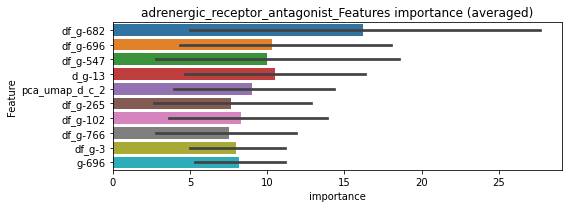

len(train_index) : 2164
len(valid_index) : 2165
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288125	valid_1's binary_logloss: 0.156228


len(train_index) : 2165
len(valid_index) : 2164
================================= fold 2/2 adrenergic_receptor_antagonist=================================


Early stopping, best iteration is:
[95]	training's binary_logloss: 0.0312579	valid_1's binary_logloss: 0.155799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288447	valid_1's binary_logloss: 0.149413


adrenergic_receptor_antagonist logloss: 0.1512271120444439
akt_inhibitor , len(trt) : 66


Early stopping, best iteration is:
[126]	training's binary_logloss: 0.0197028	valid_1's binary_logloss: 0.146653


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119158	valid_1's binary_logloss: 0.247878
[200]	training's binary_logloss: 0.029961	valid_1's binary_logloss: 0.140817
[300]	training's binary_logloss: 0.0101929	valid_1's binary_logloss: 0.108484
[400]	training's binary_logloss: 0.0049862	valid_1's binary_logloss: 0.0940379
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00373022	valid_1's binary_logloss: 0.0895368
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120705	valid_1's binary_logloss: 0.248696
[200]	training's binary_logloss: 0.0303286	valid_1's binary_logloss: 0.145159
[300]	training's binary_logloss: 0.0104145	valid_1's binary_logloss: 0.108612
[400]	training's binary_logloss: 0.00508369	valid_1's binary_logloss: 0.094138
[500]	training's binary_logloss: 0.00325097	valid_1's binary_logloss: 0.0883225
[600]	training's binary_logloss: 0.00244669	valid_1's binary

1 / 3 AUC score:0.995
Threshold: 0.5065079863773634
Remove_noisy_labels: 26 → positive_corect_labels: 487/974
30th percentail: 0.01506
p_label_rate: 0.01155 Vs.target_rate: 0.00305, Num_p_label: 46.0, conf_0:0.01506, conf_1:0.55955
Num_p_label: 46.0, Expected: 12.1, Adj_threshold_1: 0.51
Num_p_label: 39.0, Expected: 12.1, Adj_threshold_2: 0.55
Num_p_label: 29.0, Expected: 12.1, Adj_threshold_3: 0.59
Num_p_label: 16.0, Expected: 12.1, Adj_threshold_4: 0.63
threshold:0.63, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:487.0/974, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111496	valid_1's binary_logloss: 0.260108
[200]	training's binary_logloss: 0.0269529	valid_1's binary_logloss: 0.155425
[300]	training's binary_logloss: 0.00907098	valid_1's binary_logloss: 0.120596
[400]	training's binary_logloss: 0.00445571	valid_1's binary_logloss: 0.101982
[500]	training's binary_logloss: 0.00286018	valid_1's binary_logloss: 0.0952886
[600]	training's binary_logloss: 0.00218714	valid_1's binary_logloss: 0.0913973
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.00196904	valid_1's binary_logloss: 0.0896069
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117138	valid_1's binary_logloss: 0.242994
[200]	training's binary_logloss: 0.0285168	valid_1's binary_logloss: 0.14143
[300]	training's binary_logloss: 0.00968507	valid_1's binary_logloss: 0.105904
[400]	training's binary_logloss: 0.00474306	valid_1's bin

2 / 3 AUC score:0.996
Threshold: 0.6265079863773635


Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00351098	valid_1's binary_logloss: 0.0841333


Remove_noisy_labels: 34 → positive_corect_labels: 456.0/940
30th percentail: 0.01352
p_label_rate: 0.00603 Vs.target_rate: 0.00305, Num_p_label: 24.0, conf_0:0.01226, conf_1:0.62651
threshold:0.63, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:456.0/940, y_label_rate: 0.48511
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109781	valid_1's binary_logloss: 0.260905
[200]	training's binary_logloss: 0.0260706	valid_1's binary_logloss: 0.158817
[300]	training's binary_logloss: 0.0089558	valid_1's binary_logloss: 0.132865
[400]	training's binary_logloss: 0.0044069	valid_1's binary_logloss: 0.123346
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.0038889	valid_1's binary_logloss: 0.121643
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108369	valid_1's binary_logloss: 0.257747
[200]	training's binary_logloss: 0.0262439	valid_1's binary_logloss: 0.16415
[300]	training's binary_logloss: 0.00878019	valid_1's binary_logloss: 0.133277


3 / 3 AUC score:0.986
Threshold: 0.6265079863773635
Remove_noisy_labels: 41 → positive_corect_labels: 417.0/899
30th percentail: 0.01748
p_label_rate: 0.00452 Vs.target_rate: 0.00305, Num_p_label: 18.0, conf_0:0.01748, conf_1:0.62651


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00551569	valid_1's binary_logloss: 0.124506


threshold:0.63, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:435.0/4881, y_label_rate: 0.08912


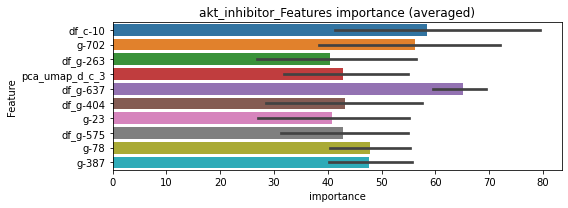

len(train_index) : 2440
len(valid_index) : 2441
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251694	valid_1's binary_logloss: 0.0651877
[200]	training's binary_logloss: 0.00425751	valid_1's binary_logloss: 0.04327
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00230827	valid_1's binary_logloss: 0.0407883


len(train_index) : 2441
len(valid_index) : 2440
================================= fold 2/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252361	valid_1's binary_logloss: 0.0705609
[200]	training's binary_logloss: 0.00442576	valid_1's binary_logloss: 0.0469673
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00194718	valid_1's binary_logloss: 0.0438442


akt_inhibitor logloss: 0.04231591932184175
aldehyde_dehydrogenase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641954	valid_1's binary_logloss: 0.0947378
[200]	training's binary_logloss: 0.0105184	valid_1's binary_logloss: 0.0253457
[300]	training's binary_logloss: 0.00334201	valid_1's binary_logloss: 0.0121729
[400]	training's binary_logloss: 0.00181685	valid_1's binary_logloss: 0.00856905
[500]	training's binary_logloss: 0.00137303	valid_1's binary_logloss: 0.0071185
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.00132623	valid_1's binary_logloss: 0.00688077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0618699	valid_1's binary_logloss: 0.109572
[200]	training's binary_logloss: 0.0101843	valid_1's binary_logloss: 0.034124
[300]	training's binary_logloss: 0.00325087	valid_1's binary_logloss: 0.0191429
[400]	training's binary_logloss: 0.00176843	valid_1's binary_logloss: 0.0138305
[500]	training's binary_logloss: 0.00134394	val

1 / 3 AUC score:1.000


Early stopping, best iteration is:
[607]	training's binary_logloss: 0.00126554	valid_1's binary_logloss: 0.0114264


Threshold: 0.4511721698459333
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentail: 0.00161
p_label_rate: 0.00100 Vs.target_rate: 0.00088, Num_p_label: 4.0, conf_0:0.00161, conf_1:0.45117
threshold:0.45, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641954	valid_1's binary_logloss: 0.0947378
[200]	training's binary_logloss: 0.0105184	valid_1's binary_logloss: 0.0253457
[300]	training's binary_logloss: 0.00334201	valid_1's binary_logloss: 0.0121729
[400]	training's binary_logloss: 0.00181685	valid_1's binary_logloss: 0.00856905
[500]	training's binary_logloss: 0.00137303	valid_1's binary_logloss: 0.0071185
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.00132623	valid_1's binary_logloss: 0.00688077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0618699	valid_1's binary_logloss: 0.109572
[200]	training's binary_logloss: 0.0101843	valid_1's binary_logloss: 0.034124
[300]	training's binary_logloss: 0.00325087	valid_1's binary_logloss: 0.0191429
[400]	training's binary_logloss: 0.00176843	valid_1's binary_logloss: 0.0138305
[500]	training's binary_logloss: 0.00134394	val

2 / 3 AUC score:1.000
Threshold: 0.4511721698459333
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentail: 0.00161
p_label_rate: 0.00100 Vs.target_rate: 0.00088, Num_p_label: 4.0, conf_0:0.00161, conf_1:0.45117
threshold:0.45, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641954	valid_1's binary_logloss: 0.0947378
[200]	training's binary_logloss: 0.0105184	valid_1's binary_logloss: 0.0253457
[300]	training's binary_logloss: 0.00334201	valid_1's binary_logloss: 0.0121729
[400]	training's binary_logloss: 0.00181685	valid_1's binary_logloss: 0.00856905
[500]	training's binary_logloss: 0.00137303	valid_1's binary_logloss: 0.0071185
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.00132623	valid_1's binary_logloss: 0.00688077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0618699	valid_1's binary_logloss: 0.109572
[200]	training's binary_logloss: 0.0101843	valid_1's binary_logloss: 0.034124
[300]	training's binary_logloss: 0.00325087	valid_1's binary_logloss: 0.0191429
[400]	training's binary_logloss: 0.00176843	valid_1's binary_logloss: 0.0138305
[500]	training's binary_logloss: 0.00134394	val

3 / 3 AUC score:1.000
Threshold: 0.4511721698459333
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentail: 0.00161
p_label_rate: 0.00100 Vs.target_rate: 0.00088, Num_p_label: 4.0, conf_0:0.00161, conf_1:0.45117
threshold:0.45, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:504.0/4982, y_label_rate: 0.10116


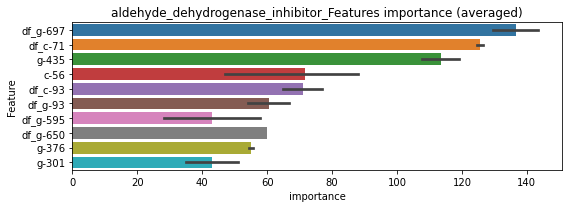

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153819	valid_1's binary_logloss: 0.0284309
[200]	training's binary_logloss: 0.00184318	valid_1's binary_logloss: 0.0100507
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000724704	valid_1's binary_logloss: 0.00811776


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153151	valid_1's binary_logloss: 0.0264273
[200]	training's binary_logloss: 0.0017885	valid_1's binary_logloss: 0.00937016
[300]	training's binary_logloss: 0.000528829	valid_1's binary_logloss: 0.00780676
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000553223	valid_1's binary_logloss: 0.00777593


aldehyde_dehydrogenase_inhibitor logloss: 0.007946848625029174
alk_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100766	valid_1's binary_logloss: 0.20793
[200]	training's binary_logloss: 0.0226	valid_1's binary_logloss: 0.101411
[300]	training's binary_logloss: 0.00740965	valid_1's binary_logloss: 0.0686717
[400]	training's binary_logloss: 0.00367161	valid_1's binary_logloss: 0.0574478
[500]	training's binary_logloss: 0.00240435	valid_1's binary_logloss: 0.05152
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.0019708	valid_1's binary_logloss: 0.0486734
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103245	valid_1's binary_logloss: 0.196915
[200]	training's binary_logloss: 0.0235795	valid_1's binary_logloss: 0.0835427
[300]	training's binary_logloss: 0.00787295	valid_1's binary_logloss: 0.0470322
[400]	training's binary_logloss: 0.00388827	valid_1's binary_logloss: 0.0324299
[500]	training's binary_logloss: 0.00253104	valid_1's binar

1 / 3 AUC score:1.000
Threshold: 0.45094135137245805
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
30th percentail: 0.00743
p_label_rate: 0.01105 Vs.target_rate: 0.00194, Num_p_label: 44.0, conf_0:0.00743, conf_1:0.50838
Num_p_label: 44.0, Expected: 7.7, Adj_threshold_1: 0.45
Num_p_label: 29.0, Expected: 7.7, Adj_threshold_2: 0.49
Num_p_label: 24.0, Expected: 7.7, Adj_threshold_3: 0.53
Num_p_label: 20.0, Expected: 7.7, Adj_threshold_4: 0.57
Num_p_label: 17.0, Expected: 7.7, Adj_threshold_5: 0.61
Num_p_label: 11.0, Expected: 7.7, Adj_threshold_6: 0.65
threshold:0.65, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0969101	valid_1's binary_logloss: 0.195021
[200]	training's binary_logloss: 0.0217552	valid_1's binary_logloss: 0.094797
[300]	training's binary_logloss: 0.00723391	valid_1's binary_logloss: 0.0626471
[400]	training's binary_logloss: 0.00366024	valid_1's binary_logloss: 0.0508582
[500]	training's binary_logloss: 0.00243548	valid_1's binary_logloss: 0.0466779
[600]	training's binary_logloss: 0.00194151	valid_1's binary_logloss: 0.0442427
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.00182133	valid_1's binary_logloss: 0.043386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102621	valid_1's binary_logloss: 0.212665
[200]	training's binary_logloss: 0.023413	valid_1's binary_logloss: 0.102099
[300]	training's binary_logloss: 0.0076278	valid_1's binary_logloss: 0.0654776
[400]	training's binary_logloss: 0.00372822	valid_1's b

2 / 3 AUC score:0.999
Threshold: 0.6509413513724581
Remove_noisy_labels: 14 → positive_corect_labels: 484.0/978
30th percentail: 0.00738
p_label_rate: 0.00502 Vs.target_rate: 0.00194, Num_p_label: 20.0, conf_0:0.00738, conf_1:0.65094
threshold:0.65, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:484.0/978, y_label_rate: 0.49489
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0996813	valid_1's binary_logloss: 0.184003
[200]	training's binary_logloss: 0.0223955	valid_1's binary_logloss: 0.0799176
[300]	training's binary_logloss: 0.00735886	valid_1's binary_logloss: 0.0454758
[400]	training's binary_logloss: 0.00365079	valid_1's binary_logloss: 0.0319954
[500]	training's binary_logloss: 0.00237739	valid_1's binary_logloss: 0.0266657
[600]	training's binary_logloss: 0.00188523	valid_1's binary_logloss: 0.0239128
Early stopping, best iteration is:
[636]	training's binary_logloss: 0.00182574	valid_1's binary_logloss: 0.023596
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0975548	valid_1's binary_logloss: 0.190897
[200]	training's binary_logloss: 0.0216274	valid_1's binary_logloss: 0.0909094
[300]	training's binary_logloss: 0.00697597	valid_1's binary_logloss: 0.0583662
[400]	training's binary_logloss: 0.00351781	valid_

3 / 3 AUC score:1.000
Threshold: 0.6509413513724581
Remove_noisy_labels: 3 → positive_corect_labels: 482.0/975
30th percentail: 0.00675
p_label_rate: 0.00753 Vs.target_rate: 0.00194, Num_p_label: 30.0, conf_0:0.00675, conf_1:0.65094
Num_p_label: 30.0, Expected: 7.7, Adj_threshold_1: 0.65
Num_p_label: 25.0, Expected: 7.7, Adj_threshold_2: 0.69
Num_p_label: 23.0, Expected: 7.7, Adj_threshold_3: 0.73
Num_p_label: 19.0, Expected: 7.7, Adj_threshold_4: 0.77
Num_p_label: 17.0, Expected: 7.7, Adj_threshold_5: 0.81
Num_p_label: 12.0, Expected: 7.7, Adj_threshold_6: 0.85
Num_p_label: 9.0, Expected: 7.7, Adj_threshold_7: 0.89
threshold:0.89, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:491.0/4957, y_label_rate: 0.09905


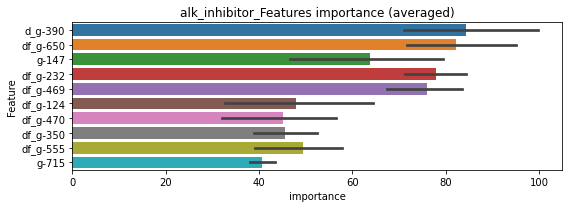

len(train_index) : 2478
len(valid_index) : 2479
================================= fold 1/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248347	valid_1's binary_logloss: 0.058986
[200]	training's binary_logloss: 0.00417365	valid_1's binary_logloss: 0.0313484
[300]	training's binary_logloss: 0.00119912	valid_1's binary_logloss: 0.0247534
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00110541	valid_1's binary_logloss: 0.0245208


len(train_index) : 2479
len(valid_index) : 2478
================================= fold 2/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259511	valid_1's binary_logloss: 0.0609094
[200]	training's binary_logloss: 0.00440995	valid_1's binary_logloss: 0.0324056
[300]	training's binary_logloss: 0.00123732	valid_1's binary_logloss: 0.026304
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00112819	valid_1's binary_logloss: 0.0259697


alk_inhibitor logloss: 0.025245075750692136
ampk_activator , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049898	valid_1's binary_logloss: 0.0778709
[200]	training's binary_logloss: 0.00705784	valid_1's binary_logloss: 0.0190458
[300]	training's binary_logloss: 0.00225619	valid_1's binary_logloss: 0.00911141
[400]	training's binary_logloss: 0.00132354	valid_1's binary_logloss: 0.00645367
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00113728	valid_1's binary_logloss: 0.00567526
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0501789	valid_1's binary_logloss: 0.0732196
[200]	training's binary_logloss: 0.00703425	valid_1's binary_logloss: 0.0223424
[300]	training's binary_logloss: 0.00223428	valid_1's binary_logloss: 0.0125279
[400]	training's binary_logloss: 0.00131374	valid_1's binary_logloss: 0.00956388
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00113224	valid_1's binary_logloss: 0.00864557


1 / 3 AUC score:1.000
Threshold: 0.747506254524591
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentail: 0.00098
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00098, conf_1:0.74751
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.75
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_2: 0.71
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_3: 0.67
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_4: 0.63
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_5: 0.59
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_6: 0.55
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_7: 0.51
Num_p_label: 2.0, Expected: 2.2, Adj_threshold_8: 0.47
threshold:0.47, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049898	valid_1's binary_logloss: 0.0778709
[200]	training's binary_logloss: 0.00705784	valid_1's binary_logloss: 0.0190458
[300]	training's binary_logloss: 0.00225619	valid_1's binary_logloss: 0.00911141
[400]	training's binary_logloss: 0.00132354	valid_1's binary_logloss: 0.00645367
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00113728	valid_1's binary_logloss: 0.00567526
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0501789	valid_1's binary_logloss: 0.0732196
[200]	training's binary_logloss: 0.00703425	valid_1's binary_logloss: 0.0223424
[300]	training's binary_logloss: 0.00223428	valid_1's binary_logloss: 0.0125279
[400]	training's binary_logloss: 0.00131374	valid_1's binary_logloss: 0.00956388
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00113224	valid_1's binary_logloss: 0.00864557


2 / 3 AUC score:1.000
Threshold: 0.46750625452459077
Remove_noisy_labels: 2 → positive_corect_labels: 500.0/998
30th percentail: 0.00098
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00098, conf_1:0.46751
threshold:0.47, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/998, y_label_rate: 0.50100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0498805	valid_1's binary_logloss: 0.0736252
[200]	training's binary_logloss: 0.00698151	valid_1's binary_logloss: 0.0171309
[300]	training's binary_logloss: 0.00223296	valid_1's binary_logloss: 0.0078137
[400]	training's binary_logloss: 0.00129692	valid_1's binary_logloss: 0.00538671
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00111199	valid_1's binary_logloss: 0.00485496
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0507029	valid_1's binary_logloss: 0.0726524
[200]	training's binary_logloss: 0.0071436	valid_1's binary_logloss: 0.0181689
[300]	training's binary_logloss: 0.00225517	valid_1's binary_logloss: 0.00865466
[400]	training's binary_logloss: 0.00131578	valid_1's binary_logloss: 0.00603848


3 / 3 AUC score:1.000
Threshold: 0.46750625452459077


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00113106	valid_1's binary_logloss: 0.00526628


Remove_noisy_labels: 0 → positive_corect_labels: 500.0/998
30th percentail: 0.00102
p_label_rate: 0.00075 Vs.target_rate: 0.00055, Num_p_label: 3.0, conf_0:0.00102, conf_1:0.46751
threshold:0.47, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4980, y_label_rate: 0.10100


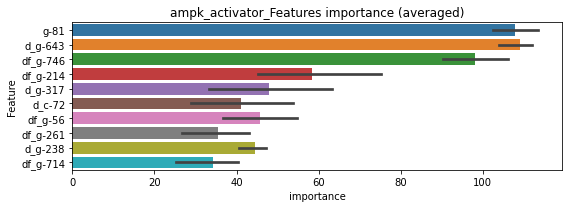

len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123298	valid_1's binary_logloss: 0.0209405
[200]	training's binary_logloss: 0.00130949	valid_1's binary_logloss: 0.00794727
[300]	training's binary_logloss: 0.000392696	valid_1's binary_logloss: 0.0061643
[400]	training's binary_logloss: 0.000227695	valid_1's binary_logloss: 0.00562134
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.000211042	valid_1's binary_logloss: 0.00554582


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123874	valid_1's binary_logloss: 0.016244
[200]	training's binary_logloss: 0.00131102	valid_1's binary_logloss: 0.00478985
[300]	training's binary_logloss: 0.000385235	valid_1's binary_logloss: 0.00421574


ampk_activator logloss: 0.004872022937154812


Early stopping, best iteration is:
[309]	training's binary_logloss: 0.000361434	valid_1's binary_logloss: 0.00419823


analgesic , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467512	valid_1's binary_logloss: 0.0710775
[200]	training's binary_logloss: 0.00672932	valid_1's binary_logloss: 0.0184986
[300]	training's binary_logloss: 0.00217844	valid_1's binary_logloss: 0.00850509
[400]	training's binary_logloss: 0.00128749	valid_1's binary_logloss: 0.00571086
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00110094	valid_1's binary_logloss: 0.00508745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471091	valid_1's binary_logloss: 0.0660328
[200]	training's binary_logloss: 0.00651709	valid_1's binary_logloss: 0.0163528
[300]	training's binary_logloss: 0.00219838	valid_1's binary_logloss: 0.00800018
[400]	training's binary_logloss: 0.00129549	valid_1's binary_logloss: 0.0054957
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00113173	valid_1's binary_logloss: 0.00494673


1 / 3 AUC score:1.000
Threshold: 0.5551646623494461
Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
30th percentail: 0.00087
p_label_rate: 0.00000 Vs.target_rate: 0.00055, Num_p_label: 0.0, conf_0:0.00087, conf_1:0.55516
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_1: 0.56
Num_p_label: 2.0, Expected: 2.2, Adj_threshold_2: 0.52
threshold:0.52, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467512	valid_1's binary_logloss: 0.0710775
[200]	training's binary_logloss: 0.00672932	valid_1's binary_logloss: 0.0184986
[300]	training's binary_logloss: 0.00217844	valid_1's binary_logloss: 0.00850509
[400]	training's binary_logloss: 0.00128749	valid_1's binary_logloss: 0.00571086
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00110094	valid_1's binary_logloss: 0.00508745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471091	valid_1's binary_logloss: 0.0660328
[200]	training's binary_logloss: 0.00651709	valid_1's binary_logloss: 0.0163528
[300]	training's binary_logloss: 0.00219838	valid_1's binary_logloss: 0.00800018
[400]	training's binary_logloss: 0.00129549	valid_1's binary_logloss: 0.0054957
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00113173	valid_1's binary_logloss: 0.00494673


2 / 3 AUC score:1.000
Threshold: 0.515164662349446
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentail: 0.00087
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00087, conf_1:0.51516
threshold:0.52, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/1000, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467512	valid_1's binary_logloss: 0.0710775
[200]	training's binary_logloss: 0.00672932	valid_1's binary_logloss: 0.0184986
[300]	training's binary_logloss: 0.00217844	valid_1's binary_logloss: 0.00850509
[400]	training's binary_logloss: 0.00128749	valid_1's binary_logloss: 0.00571086
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00110094	valid_1's binary_logloss: 0.00508745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471091	valid_1's binary_logloss: 0.0660328
[200]	training's binary_logloss: 0.00651709	valid_1's binary_logloss: 0.0163528
[300]	training's binary_logloss: 0.00219838	valid_1's binary_logloss: 0.00800018
[400]	training's binary_logloss: 0.00129549	valid_1's binary_logloss: 0.0054957
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00113173	valid_1's binary_logloss: 0.00494673


3 / 3 AUC score:1.000
Threshold: 0.515164662349446
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
30th percentail: 0.00087
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00087, conf_1:0.51516
threshold:0.52, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4982, y_label_rate: 0.10076


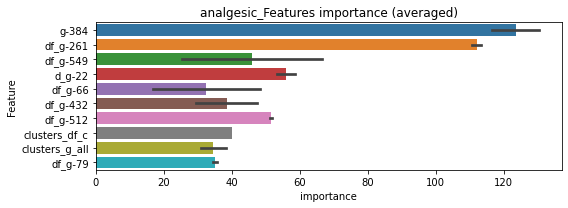

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0119638	valid_1's binary_logloss: 0.0179458
[200]	training's binary_logloss: 0.00126108	valid_1's binary_logloss: 0.00408528
[300]	training's binary_logloss: 0.000381302	valid_1's binary_logloss: 0.00238153
[400]	training's binary_logloss: 0.000222905	valid_1's binary_logloss: 0.00203496
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.000212077	valid_1's binary_logloss: 0.00200873


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0119104	valid_1's binary_logloss: 0.0153684
[200]	training's binary_logloss: 0.00125933	valid_1's binary_logloss: 0.00317247
[300]	training's binary_logloss: 0.000381109	valid_1's binary_logloss: 0.0019747
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000249527	valid_1's binary_logloss: 0.00184079


analgesic logloss: 0.0019247626403693801
androgen_receptor_agonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101014	valid_1's binary_logloss: 0.22335
[200]	training's binary_logloss: 0.0237971	valid_1's binary_logloss: 0.132194
[300]	training's binary_logloss: 0.00805972	valid_1's binary_logloss: 0.103331
[400]	training's binary_logloss: 0.00405493	valid_1's binary_logloss: 0.0933041
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.00349989	valid_1's binary_logloss: 0.0901865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103119	valid_1's binary_logloss: 0.226003
[200]	training's binary_logloss: 0.0243076	valid_1's binary_logloss: 0.127457
[300]	training's binary_logloss: 0.00816606	valid_1's binary_logloss: 0.0896236
[400]	training's binary_logloss: 0.00414243	valid_1's binary_logloss: 0.0738508
[500]	training's binary_logloss: 0.00273178	valid_1's binary_logloss: 0.066472
Early stopping, best iteration is:
[570]	training's bina

1 / 3 AUC score:0.995
Threshold: 0.26664801918841674
Remove_noisy_labels: 28 → positive_corect_labels: 486/972
30th percentail: 0.01460
p_label_rate: 0.01632 Vs.target_rate: 0.00222, Num_p_label: 65.0, conf_0:0.01460, conf_1:0.41774
Num_p_label: 65.0, Expected: 8.8, Adj_threshold_1: 0.27
Num_p_label: 46.0, Expected: 8.8, Adj_threshold_2: 0.31
Num_p_label: 27.0, Expected: 8.8, Adj_threshold_3: 0.35
Num_p_label: 20.0, Expected: 8.8, Adj_threshold_4: 0.39
Num_p_label: 15.0, Expected: 8.8, Adj_threshold_5: 0.43
Num_p_label: 9.0, Expected: 8.8, Adj_threshold_6: 0.47
threshold:0.47, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:486.0/972, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10224	valid_1's binary_logloss: 0.192656
[200]	training's binary_logloss: 0.023257	valid_1's binary_logloss: 0.0873545
[300]	training's binary_logloss: 0.00790683	valid_1's binary_logloss: 0.055549
[400]	training's binary_logloss: 0.00399359	valid_1's binary_logloss: 0.0411508
[500]	training's binary_logloss: 0.00265062	valid_1's binary_logloss: 0.0348039
[600]	training's binary_logloss: 0.00211586	valid_1's binary_logloss: 0.0316991
Early stopping, best iteration is:
[651]	training's binary_logloss: 0.00198088	valid_1's binary_logloss: 0.0310221
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0914781	valid_1's binary_logloss: 0.203022
[200]	training's binary_logloss: 0.0206831	valid_1's binary_logloss: 0.110723
[300]	training's binary_logloss: 0.00705908	valid_1's binary_logloss: 0.0760424
[400]	training's binary_logloss: 0.0036809	valid_1's b

2 / 3 AUC score:1.000
Threshold: 0.46664801918841664
Remove_noisy_labels: 9 → positive_corect_labels: 477.0/963
30th percentail: 0.01099
p_label_rate: 0.00251 Vs.target_rate: 0.00222, Num_p_label: 10.0, conf_0:0.01099, conf_1:0.46665
threshold:0.47, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:477.0/963, y_label_rate: 0.49533
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0994731	valid_1's binary_logloss: 0.193453
[200]	training's binary_logloss: 0.0227626	valid_1's binary_logloss: 0.0933883
[300]	training's binary_logloss: 0.00766558	valid_1's binary_logloss: 0.0576364
[400]	training's binary_logloss: 0.00391412	valid_1's binary_logloss: 0.0449639
[500]	training's binary_logloss: 0.00261451	valid_1's binary_logloss: 0.0388084
[600]	training's binary_logloss: 0.00208216	valid_1's binary_logloss: 0.0354512
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.0019357	valid_1's binary_logloss: 0.0345222
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0911831	valid_1's binary_logloss: 0.197595
[200]	training's binary_logloss: 0.0204413	valid_1's binary_logloss: 0.100436
[300]	training's binary_logloss: 0.00702707	valid_1's binary_logloss: 0.0700494
[400]	training's binary_logloss: 0.00364601	valid_1

3 / 3 AUC score:0.999
Threshold: 0.46664801918841664
Remove_noisy_labels: 9 → positive_corect_labels: 470.0/954
30th percentail: 0.00993
p_label_rate: 0.00276 Vs.target_rate: 0.00222, Num_p_label: 11.0, conf_0:0.00993, conf_1:0.46665
threshold:0.47, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:481.0/4936, y_label_rate: 0.09745


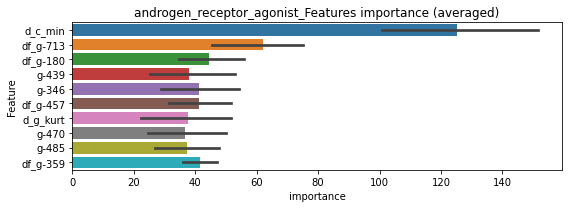

len(train_index) : 2468
len(valid_index) : 2468
================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242605	valid_1's binary_logloss: 0.0598089
[200]	training's binary_logloss: 0.00385423	valid_1's binary_logloss: 0.0349596
[300]	training's binary_logloss: 0.00112182	valid_1's binary_logloss: 0.0305871
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000908752	valid_1's binary_logloss: 0.0303001


len(train_index) : 2468
len(valid_index) : 2468
================================= fold 2/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021755	valid_1's binary_logloss: 0.0527311
[200]	training's binary_logloss: 0.00364069	valid_1's binary_logloss: 0.0283057
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00166601	valid_1's binary_logloss: 0.0251981


androgen_receptor_agonist logloss: 0.027749072848411813
androgen_receptor_antagonist , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144593	valid_1's binary_logloss: 0.323168
[200]	training's binary_logloss: 0.0407546	valid_1's binary_logloss: 0.223565
[300]	training's binary_logloss: 0.0149061	valid_1's binary_logloss: 0.186551
[400]	training's binary_logloss: 0.00719893	valid_1's binary_logloss: 0.169116
[500]	training's binary_logloss: 0.00441483	valid_1's binary_logloss: 0.160534
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00418004	valid_1's binary_logloss: 0.159337
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142884	valid_1's binary_logloss: 0.32788
[200]	training's binary_logloss: 0.0408672	valid_1's binary_logloss: 0.219098
[300]	training's binary_logloss: 0.0149143	valid_1's binary_logloss: 0.179201
[400]	training's binary_logloss: 0.00713762	valid_1's binary_logloss: 0.158822
[500]	training's binary_logloss: 0.00434668	valid_1's binary_l

1 / 3 AUC score:0.982
Threshold: 0.4121925137543049
Remove_noisy_labels: 50 → positive_corect_labels: 475/950
30th percentail: 0.04612
p_label_rate: 0.03792 Vs.target_rate: 0.00411, Num_p_label: 151.0, conf_0:0.02357, conf_1:0.46913
Num_p_label: 151.0, Expected: 16.4, Adj_threshold_1: 0.41
Num_p_label: 105.0, Expected: 16.4, Adj_threshold_2: 0.45
Num_p_label: 75.0, Expected: 16.4, Adj_threshold_3: 0.49
Num_p_label: 43.0, Expected: 16.4, Adj_threshold_4: 0.53
Num_p_label: 25.0, Expected: 16.4, Adj_threshold_5: 0.57
Num_p_label: 18.0, Expected: 16.4, Adj_threshold_6: 0.61
threshold:0.61, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:475.0/950, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134068	valid_1's binary_logloss: 0.303536
[200]	training's binary_logloss: 0.0369177	valid_1's binary_logloss: 0.196598
[300]	training's binary_logloss: 0.0132604	valid_1's binary_logloss: 0.149962
[400]	training's binary_logloss: 0.00639171	valid_1's binary_logloss: 0.131065
[500]	training's binary_logloss: 0.00398643	valid_1's binary_logloss: 0.118753
[600]	training's binary_logloss: 0.00290722	valid_1's binary_logloss: 0.111949
Early stopping, best iteration is:
[653]	training's binary_logloss: 0.00259561	valid_1's binary_logloss: 0.109664
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137725	valid_1's binary_logloss: 0.300016
[200]	training's binary_logloss: 0.0376792	valid_1's binary_logloss: 0.187419
[300]	training's binary_logloss: 0.0133327	valid_1's binary_logloss: 0.141149
[400]	training's binary_logloss: 0.00642021	valid_1's binary_

2 / 3 AUC score:0.995
Threshold: 0.612192513754305
Remove_noisy_labels: 23 → positive_corect_labels: 458.0/927
30th percentail: 0.03681
p_label_rate: 0.01306 Vs.target_rate: 0.00411, Num_p_label: 52.0, conf_0:0.02319, conf_1:0.61219
Num_p_label: 52.0, Expected: 16.4, Adj_threshold_1: 0.61
Num_p_label: 37.0, Expected: 16.4, Adj_threshold_2: 0.65
Num_p_label: 26.0, Expected: 16.4, Adj_threshold_3: 0.69
Num_p_label: 17.0, Expected: 16.4, Adj_threshold_4: 0.73
threshold:0.73, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:458.0/927, y_label_rate: 0.49407
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131623	valid_1's binary_logloss: 0.290067
[200]	training's binary_logloss: 0.0362585	valid_1's binary_logloss: 0.180846
[300]	training's binary_logloss: 0.0129406	valid_1's binary_logloss: 0.139886
[400]	training's binary_logloss: 0.00622562	valid_1's binary_logloss: 0.118635
[500]	training's binary_logloss: 0.00389124	valid_1's binary_logloss: 0.106648
[600]	training's binary_logloss: 0.00287951	valid_1's binary_logloss: 0.0999084
Early stopping, best iteration is:
[654]	training's binary_logloss: 0.00255704	valid_1's binary_logloss: 0.0976994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131827	valid_1's binary_logloss: 0.281455
[200]	training's binary_logloss: 0.0354232	valid_1's binary_logloss: 0.164743
[300]	training's binary_logloss: 0.0124709	valid_1's binary_logloss: 0.117363
[400]	training's binary_logloss: 0.00612954	valid_1's binar

3 / 3 AUC score:0.998
Threshold: 0.732192513754305
Remove_noisy_labels: 26 → positive_corect_labels: 432.0/901
30th percentail: 0.03035
p_label_rate: 0.00452 Vs.target_rate: 0.00411, Num_p_label: 18.0, conf_0:0.02127, conf_1:0.73219
threshold:0.73, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:450.0/4883, y_label_rate: 0.09216


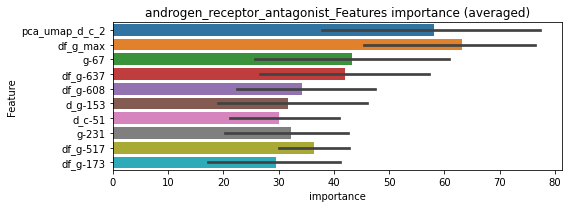

len(train_index) : 2441
len(valid_index) : 2442
================================= fold 1/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367553	valid_1's binary_logloss: 0.0930213
[200]	training's binary_logloss: 0.00819906	valid_1's binary_logloss: 0.0622681
[300]	training's binary_logloss: 0.00237022	valid_1's binary_logloss: 0.0555756
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.0017667	valid_1's binary_logloss: 0.0547742


len(train_index) : 2442
len(valid_index) : 2441
================================= fold 2/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364818	valid_1's binary_logloss: 0.0975298
[200]	training's binary_logloss: 0.00793203	valid_1's binary_logloss: 0.06651
[300]	training's binary_logloss: 0.00231305	valid_1's binary_logloss: 0.0596784
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00201192	valid_1's binary_logloss: 0.058823


androgen_receptor_antagonist logloss: 0.056798215913392174
anesthetic_-_local , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140699	valid_1's binary_logloss: 0.280311
[200]	training's binary_logloss: 0.0388968	valid_1's binary_logloss: 0.167867
[300]	training's binary_logloss: 0.0137261	valid_1's binary_logloss: 0.124941
[400]	training's binary_logloss: 0.00664466	valid_1's binary_logloss: 0.104762
[500]	training's binary_logloss: 0.00415624	valid_1's binary_logloss: 0.0953276
[600]	training's binary_logloss: 0.00302317	valid_1's binary_logloss: 0.0889866
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.002648	valid_1's binary_logloss: 0.0873262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131427	valid_1's binary_logloss: 0.297274
[200]	training's binary_logloss: 0.0354031	valid_1's binary_logloss: 0.195697
[300]	training's binary_logloss: 0.0126302	valid_1's binary_logloss: 0.15754
[400]	training's binary_logloss: 0.00615372	valid_1's binary_

1 / 3 AUC score:0.991


Early stopping, best iteration is:
[432]	training's binary_logloss: 0.0051973	valid_1's binary_logloss: 0.137997


Threshold: 0.3916732678676429
Remove_noisy_labels: 32 → positive_corect_labels: 484/968
30th percentail: 0.03807
p_label_rate: 0.02310 Vs.target_rate: 0.00370, Num_p_label: 92.0, conf_0:0.03807, conf_1:0.48896
Num_p_label: 92.0, Expected: 14.7, Adj_threshold_1: 0.39
Num_p_label: 68.0, Expected: 14.7, Adj_threshold_2: 0.43
Num_p_label: 48.0, Expected: 14.7, Adj_threshold_3: 0.47
Num_p_label: 29.0, Expected: 14.7, Adj_threshold_4: 0.51
Num_p_label: 15.0, Expected: 14.7, Adj_threshold_5: 0.55
threshold:0.55, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:484.0/968, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133823	valid_1's binary_logloss: 0.286097
[200]	training's binary_logloss: 0.0364455	valid_1's binary_logloss: 0.180537
[300]	training's binary_logloss: 0.0127826	valid_1's binary_logloss: 0.135771
[400]	training's binary_logloss: 0.00624523	valid_1's binary_logloss: 0.112221
[500]	training's binary_logloss: 0.00393214	valid_1's binary_logloss: 0.100743
[600]	training's binary_logloss: 0.00289532	valid_1's binary_logloss: 0.0936516
Early stopping, best iteration is:
[608]	training's binary_logloss: 0.00284241	valid_1's binary_logloss: 0.0931774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131196	valid_1's binary_logloss: 0.27717
[200]	training's binary_logloss: 0.0348754	valid_1's binary_logloss: 0.176209
[300]	training's binary_logloss: 0.0123827	valid_1's binary_logloss: 0.137758
[400]	training's binary_logloss: 0.00596925	valid_1's binary

2 / 3 AUC score:0.994
Threshold: 0.5516732678676429
Remove_noisy_labels: 23 → positive_corect_labels: 471.0/945
30th percentail: 0.03158
p_label_rate: 0.00804 Vs.target_rate: 0.00370, Num_p_label: 32.0, conf_0:0.03158, conf_1:0.55167
threshold:0.55, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:471.0/945, y_label_rate: 0.49841
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127841	valid_1's binary_logloss: 0.283602
[200]	training's binary_logloss: 0.0346542	valid_1's binary_logloss: 0.17627
[300]	training's binary_logloss: 0.0121305	valid_1's binary_logloss: 0.126428
[400]	training's binary_logloss: 0.00597948	valid_1's binary_logloss: 0.102638
[500]	training's binary_logloss: 0.00380151	valid_1's binary_logloss: 0.0905214
[600]	training's binary_logloss: 0.00283833	valid_1's binary_logloss: 0.0837762
[700]	training's binary_logloss: 0.00236729	valid_1's binary_logloss: 0.0794845
Early stopping, best iteration is:
[720]	training's binary_logloss: 0.00230172	valid_1's binary_logloss: 0.0784962
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127568	valid_1's binary_logloss: 0.279076
[200]	training's binary_logloss: 0.0343727	valid_1's binary_logloss: 0.168449
[300]	training's binary_logloss: 0.0119416	valid_1's bina

3 / 3 AUC score:0.996
Threshold: 0.5516732678676429
Remove_noisy_labels: 18 → positive_corect_labels: 460.0/927
30th percentail: 0.02389
p_label_rate: 0.00954 Vs.target_rate: 0.00370, Num_p_label: 38.0, conf_0:0.01717, conf_1:0.55167
threshold:0.55, positive p_label:38.0/3982, p_label_rate: 0.00954
positive y_label:498.0/4909, y_label_rate: 0.10145


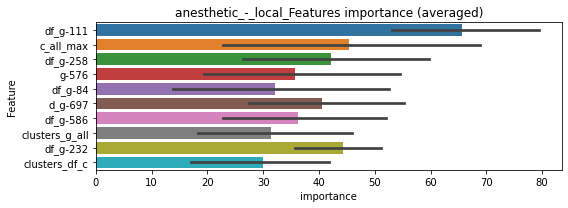

len(train_index) : 2454
len(valid_index) : 2455
================================= fold 1/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371521	valid_1's binary_logloss: 0.102871
[200]	training's binary_logloss: 0.00834052	valid_1's binary_logloss: 0.0763832
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00349618	valid_1's binary_logloss: 0.0721341


len(train_index) : 2455
len(valid_index) : 2454
================================= fold 2/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403682	valid_1's binary_logloss: 0.0930511
[200]	training's binary_logloss: 0.00898131	valid_1's binary_logloss: 0.0578424
[300]	training's binary_logloss: 0.00256152	valid_1's binary_logloss: 0.0495174
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00180779	valid_1's binary_logloss: 0.0483497


anesthetic_-_local logloss: 0.060244307182398746
angiogenesis_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0918671	valid_1's binary_logloss: 0.157299
[200]	training's binary_logloss: 0.0193491	valid_1's binary_logloss: 0.0634201
[300]	training's binary_logloss: 0.00643778	valid_1's binary_logloss: 0.0349645
[400]	training's binary_logloss: 0.00328659	valid_1's binary_logloss: 0.0247728
[500]	training's binary_logloss: 0.00219932	valid_1's binary_logloss: 0.0208979
[600]	training's binary_logloss: 0.00178401	valid_1's binary_logloss: 0.0185774
Early stopping, best iteration is:
[671]	training's binary_logloss: 0.00168711	valid_1's binary_logloss: 0.0179361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0873643	valid_1's binary_logloss: 0.17246
[200]	training's binary_logloss: 0.0174532	valid_1's binary_logloss: 0.0787409
[300]	training's binary_logloss: 0.00572666	valid_1's binary_logloss: 0.0511305
[400]	training's binary_logloss: 0.00296618	valid_

1 / 3 AUC score:1.000
Threshold: 0.5650036516816149
Remove_noisy_labels: 4 → positive_corect_labels: 498/996
30th percentail: 0.00621
p_label_rate: 0.00050 Vs.target_rate: 0.00166, Num_p_label: 2.0, conf_0:0.00621, conf_1:0.56500
Num_p_label: 2.0, Expected: 6.6, Adj_threshold_1: 0.57
Num_p_label: 2.0, Expected: 6.6, Adj_threshold_2: 0.53
Num_p_label: 3.0, Expected: 6.6, Adj_threshold_3: 0.49
Num_p_label: 5.0, Expected: 6.6, Adj_threshold_4: 0.45
threshold:0.45, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0873042	valid_1's binary_logloss: 0.158023
[200]	training's binary_logloss: 0.018274	valid_1's binary_logloss: 0.065552
[300]	training's binary_logloss: 0.00595598	valid_1's binary_logloss: 0.0375877
[400]	training's binary_logloss: 0.00305949	valid_1's binary_logloss: 0.0279882
[500]	training's binary_logloss: 0.00208058	valid_1's binary_logloss: 0.0239778
[600]	training's binary_logloss: 0.00172833	valid_1's binary_logloss: 0.0219367
Early stopping, best iteration is:
[618]	training's binary_logloss: 0.00169492	valid_1's binary_logloss: 0.0216552
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0898433	valid_1's binary_logloss: 0.170461
[200]	training's binary_logloss: 0.0184862	valid_1's binary_logloss: 0.0736284
[300]	training's binary_logloss: 0.00597465	valid_1's binary_logloss: 0.0447673
[400]	training's binary_logloss: 0.00308183	valid_1

2 / 3 AUC score:1.000
Threshold: 0.44500365168161493
Remove_noisy_labels: 3 → positive_corect_labels: 498.0/993
30th percentail: 0.00629
p_label_rate: 0.00201 Vs.target_rate: 0.00166, Num_p_label: 8.0, conf_0:0.00629, conf_1:0.45806
threshold:0.45, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:498.0/993, y_label_rate: 0.50151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900323	valid_1's binary_logloss: 0.179685
[200]	training's binary_logloss: 0.0185558	valid_1's binary_logloss: 0.0828068
[300]	training's binary_logloss: 0.00604863	valid_1's binary_logloss: 0.0532539
[400]	training's binary_logloss: 0.00311677	valid_1's binary_logloss: 0.0429338
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00242761	valid_1's binary_logloss: 0.0392378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0865562	valid_1's binary_logloss: 0.165174
[200]	training's binary_logloss: 0.0179819	valid_1's binary_logloss: 0.0729266
[300]	training's binary_logloss: 0.00597801	valid_1's binary_logloss: 0.0425709
[400]	training's binary_logloss: 0.0030525	valid_1's binary_logloss: 0.0315911
[500]	training's binary_logloss: 0.00206934	valid_1's binary_logloss: 0.026932
Early stopping, best iteration is:
[582]	training's

3 / 3 AUC score:1.000
Threshold: 0.44500365168161493
Remove_noisy_labels: 5 → positive_corect_labels: 496.0/988
30th percentail: 0.00865
p_label_rate: 0.00151 Vs.target_rate: 0.00166, Num_p_label: 6.0, conf_0:0.00865, conf_1:0.46556
threshold:0.45, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:502.0/4970, y_label_rate: 0.10101


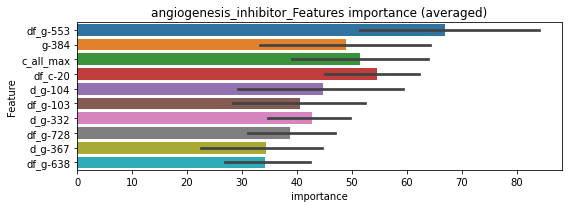

len(train_index) : 2485
len(valid_index) : 2485
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023809	valid_1's binary_logloss: 0.0411725
[200]	training's binary_logloss: 0.00388389	valid_1's binary_logloss: 0.0155603
[300]	training's binary_logloss: 0.00109883	valid_1's binary_logloss: 0.0106364
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000683783	valid_1's binary_logloss: 0.00986872


len(train_index) : 2485
len(valid_index) : 2485
================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229617	valid_1's binary_logloss: 0.0489777
[200]	training's binary_logloss: 0.00354335	valid_1's binary_logloss: 0.0252085
[300]	training's binary_logloss: 0.00102763	valid_1's binary_logloss: 0.020796
[400]	training's binary_logloss: 0.000522508	valid_1's binary_logloss: 0.0187618
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.000478041	valid_1's binary_logloss: 0.0184663


angiogenesis_inhibitor logloss: 0.014167486858991392
angiotensin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0954739	valid_1's binary_logloss: 0.177859
[200]	training's binary_logloss: 0.0203189	valid_1's binary_logloss: 0.0858514
[300]	training's binary_logloss: 0.00659495	valid_1's binary_logloss: 0.0590982
[400]	training's binary_logloss: 0.00332449	valid_1's binary_logloss: 0.0507557
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00242056	valid_1's binary_logloss: 0.0471604
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0931731	valid_1's binary_logloss: 0.203135
[200]	training's binary_logloss: 0.0195906	valid_1's binary_logloss: 0.104912
[300]	training's binary_logloss: 0.00632868	valid_1's binary_logloss: 0.0768103
[400]	training's binary_logloss: 0.00319048	valid_1's binary_logloss: 0.0650757


1 / 3 AUC score:0.997


Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00239669	valid_1's binary_logloss: 0.0611897


Threshold: 0.3056065718719211
Remove_noisy_labels: 22 → positive_corect_labels: 489/978
30th percentail: 0.01045
p_label_rate: 0.00728 Vs.target_rate: 0.00171, Num_p_label: 29.0, conf_0:0.01045, conf_1:0.34516
Num_p_label: 29.0, Expected: 6.8, Adj_threshold_1: 0.31
Num_p_label: 23.0, Expected: 6.8, Adj_threshold_2: 0.35
Num_p_label: 16.0, Expected: 6.8, Adj_threshold_3: 0.39
Num_p_label: 9.0, Expected: 6.8, Adj_threshold_4: 0.43
threshold:0.43, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:489.0/978, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919441	valid_1's binary_logloss: 0.170054
[200]	training's binary_logloss: 0.0197178	valid_1's binary_logloss: 0.0703509
[300]	training's binary_logloss: 0.00657673	valid_1's binary_logloss: 0.0406977
[400]	training's binary_logloss: 0.00326065	valid_1's binary_logloss: 0.0286527
[500]	training's binary_logloss: 0.00216662	valid_1's binary_logloss: 0.0237541
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00179272	valid_1's binary_logloss: 0.0214031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0910096	valid_1's binary_logloss: 0.174401
[200]	training's binary_logloss: 0.019225	valid_1's binary_logloss: 0.0811058
[300]	training's binary_logloss: 0.0062871	valid_1's binary_logloss: 0.0534596
[400]	training's binary_logloss: 0.00320808	valid_1's binary_logloss: 0.0425126
[500]	training's binary_logloss: 0.00217355	valid_1

2 / 3 AUC score:0.999
Threshold: 0.425606571871921
Remove_noisy_labels: 4 → positive_corect_labels: 487.0/974
30th percentail: 0.00761
p_label_rate: 0.00201 Vs.target_rate: 0.00171, Num_p_label: 8.0, conf_0:0.00761, conf_1:0.46050
threshold:0.43, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:487.0/974, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0925626	valid_1's binary_logloss: 0.17402
[200]	training's binary_logloss: 0.0192597	valid_1's binary_logloss: 0.0770341
[300]	training's binary_logloss: 0.00626815	valid_1's binary_logloss: 0.0469864
[400]	training's binary_logloss: 0.00316897	valid_1's binary_logloss: 0.0349961
[500]	training's binary_logloss: 0.00213644	valid_1's binary_logloss: 0.0295845
[600]	training's binary_logloss: 0.00178786	valid_1's binary_logloss: 0.0277375
Early stopping, best iteration is:
[624]	training's binary_logloss: 0.0017557	valid_1's binary_logloss: 0.0275867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0934137	valid_1's binary_logloss: 0.180526
[200]	training's binary_logloss: 0.019639	valid_1's binary_logloss: 0.0771009
[300]	training's binary_logloss: 0.00636727	valid_1's binary_logloss: 0.0448245
[400]	training's binary_logloss: 0.00322551	valid_1'

3 / 3 AUC score:1.000
Threshold: 0.425606571871921
Remove_noisy_labels: 2 → positive_corect_labels: 485.0/972
30th percentail: 0.00646
p_label_rate: 0.00301 Vs.target_rate: 0.00171, Num_p_label: 12.0, conf_0:0.00646, conf_1:0.48790
threshold:0.43, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:497.0/4954, y_label_rate: 0.10032


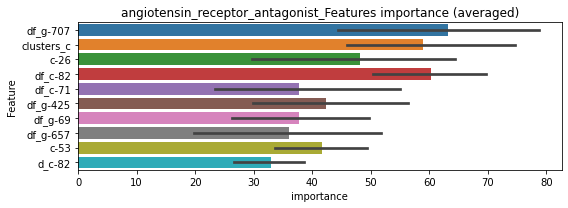

len(train_index) : 2477
len(valid_index) : 2477
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258223	valid_1's binary_logloss: 0.04917
[200]	training's binary_logloss: 0.0040101	valid_1's binary_logloss: 0.0234546
[300]	training's binary_logloss: 0.00111861	valid_1's binary_logloss: 0.0203722
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.000961764	valid_1's binary_logloss: 0.0200856


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276842	valid_1's binary_logloss: 0.049
[200]	training's binary_logloss: 0.0044763	valid_1's binary_logloss: 0.0184627
[300]	training's binary_logloss: 0.00123496	valid_1's binary_logloss: 0.0130196
[400]	training's binary_logloss: 0.000588347	valid_1's binary_logloss: 0.0118256
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.000578449	valid_1's binary_logloss: 0.0118094


angiotensin_receptor_antagonist logloss: 0.015947516179839343
anti-inflammatory , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118933	valid_1's binary_logloss: 0.28204
[200]	training's binary_logloss: 0.0317977	valid_1's binary_logloss: 0.190786
[300]	training's binary_logloss: 0.0111554	valid_1's binary_logloss: 0.1559
[400]	training's binary_logloss: 0.00556747	valid_1's binary_logloss: 0.144075
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00414621	valid_1's binary_logloss: 0.140695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124121	valid_1's binary_logloss: 0.264322
[200]	training's binary_logloss: 0.0331027	valid_1's binary_logloss: 0.164551
[300]	training's binary_logloss: 0.0116353	valid_1's binary_logloss: 0.12596
[400]	training's binary_logloss: 0.00579543	valid_1's binary_logloss: 0.110259
[500]	training's binary_logloss: 0.00363988	valid_1's binary_logloss: 0.103951
[600]	training's binary_logloss: 0.00273128	valid_1's binary_logl

1 / 3 AUC score:0.989
Threshold: 0.3969161442019058
Remove_noisy_labels: 42 → positive_corect_labels: 479/958
30th percentail: 0.02700
p_label_rate: 0.01557 Vs.target_rate: 0.00337, Num_p_label: 62.0, conf_0:0.02700, conf_1:0.39692
Num_p_label: 62.0, Expected: 13.4, Adj_threshold_1: 0.40
Num_p_label: 42.0, Expected: 13.4, Adj_threshold_2: 0.44
Num_p_label: 30.0, Expected: 13.4, Adj_threshold_3: 0.48
Num_p_label: 20.0, Expected: 13.4, Adj_threshold_4: 0.52
threshold:0.52, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:479.0/958, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111762	valid_1's binary_logloss: 0.260384
[200]	training's binary_logloss: 0.0281457	valid_1's binary_logloss: 0.168796
[300]	training's binary_logloss: 0.00992782	valid_1's binary_logloss: 0.139647
[400]	training's binary_logloss: 0.00495699	valid_1's binary_logloss: 0.125219
[500]	training's binary_logloss: 0.00321141	valid_1's binary_logloss: 0.119214
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.00274453	valid_1's binary_logloss: 0.117415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115217	valid_1's binary_logloss: 0.264267
[200]	training's binary_logloss: 0.0295266	valid_1's binary_logloss: 0.167323
[300]	training's binary_logloss: 0.0103061	valid_1's binary_logloss: 0.13205
[400]	training's binary_logloss: 0.00515443	valid_1's binary_logloss: 0.115871
[500]	training's binary_logloss: 0.00336297	valid_1's binary_

2 / 3 AUC score:0.989
Threshold: 0.5169161442019058
Remove_noisy_labels: 29 → positive_corect_labels: 450.0/929
30th percentail: 0.02120
p_label_rate: 0.00603 Vs.target_rate: 0.00337, Num_p_label: 24.0, conf_0:0.02120, conf_1:0.51692
threshold:0.52, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:450.0/929, y_label_rate: 0.48439
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107321	valid_1's binary_logloss: 0.237094
[200]	training's binary_logloss: 0.0271709	valid_1's binary_logloss: 0.136446
[300]	training's binary_logloss: 0.00938029	valid_1's binary_logloss: 0.0975973
[400]	training's binary_logloss: 0.00472698	valid_1's binary_logloss: 0.0833945
[500]	training's binary_logloss: 0.00313288	valid_1's binary_logloss: 0.0768527
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00247823	valid_1's binary_logloss: 0.0736298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107558	valid_1's binary_logloss: 0.239469
[200]	training's binary_logloss: 0.0267314	valid_1's binary_logloss: 0.14417
[300]	training's binary_logloss: 0.00943283	valid_1's binary_logloss: 0.113112
[400]	training's binary_logloss: 0.00473369	valid_1's binary_logloss: 0.103725
[500]	training's binary_logloss: 0.00308357	valid_1's bi

3 / 3 AUC score:0.995
Threshold: 0.5169161442019058
Remove_noisy_labels: 22 → positive_corect_labels: 431.0/907
30th percentail: 0.01576
p_label_rate: 0.00779 Vs.target_rate: 0.00337, Num_p_label: 31.0, conf_0:0.01576, conf_1:0.51692
threshold:0.52, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:462.0/4889, y_label_rate: 0.09450


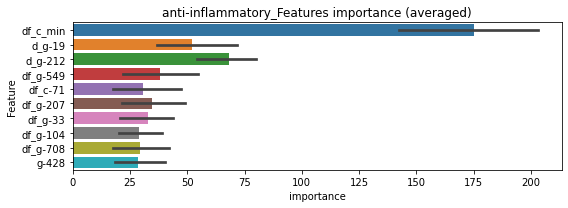

len(train_index) : 2444
len(valid_index) : 2445
================================= fold 1/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260284	valid_1's binary_logloss: 0.0782148



KeyboardInterrupt: 

In [52]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
    
    
    if DEBUG:
        for model in models:
            _importance_df = pd.DataFrame()
            _importance_df["Feature"] = train.columns[1:]
            _importance_df["importance"] = model.feature_importance(importance_type='gain')
            feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

In [ ]:
sub.to_csv('submission.csv', index=False)

In [ ]:
print(f"CV:{np.mean(scores)}")

In [ ]:
if DEBUG:
    show_feature_importance(feature_importance_df)